In [80]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
%run /home/datarian/git/master-thesis-code/notebooks/common_init.ipynb

Setup logging to file: out.log
Figure output directory saved in figure_output at /home/datarian/OneDrive/unine/Master_Thesis/ma-thesis-report/figures


In [82]:
%run /home/datarian/git/master-thesis-code/notebooks/learning_init.ipynb

Set plot_confusion_matrix(), prepare_result_store(), update_result() and run_experiments()


In [83]:
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load custom code
import kdd98.data_handler as dh
from kdd98.config import Config
from kdd98.transformers import Rescaler
import pathlib
import pickle

from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import ParameterGrid, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import confusion_matrix, precision_recall_curve, make_scorer, log_loss, precision_score, recall_score, auc, roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from glmnet import LogitNet
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin

In [84]:
# Where to save the figures

CHAPTER_ID = "learning"
# Where to save the figures
IMAGES_PATH = pathlib.Path(figure_output)

pathlib.Path(IMAGES_PATH).mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension=["pdf", "png"], resolution=300):
    if tight_layout:
        plt.tight_layout()
    [plt.savefig(pathlib.Path(IMAGES_PATH, fig_id + "." + f), 
                 format=f,
                 dpi=resolution,
                 transparent=True,
                 bbox_inches='tight') for f in fig_extension]

In [85]:
setup_file_logger("learning.log")

# Loading data, setting up common objects

## Loading Data

In [86]:
with open(pathlib.Path(Config.get("df_store"), "Xy_all_relevant.pd.pkl"), "rb") as f:
    Xy_all_relevant = pickle.load(f)

## Splitting into learning and validation sets 

In [10]:
Xy_all_relevant["targets"].TARGET_B.value_counts(normalize=True) # 5 % of recipients have donated.

0    0.949241
1    0.050759
Name: TARGET_B, dtype: float64

We want to preserve this ratio in the split datasets. scikit-learn provides a stratified sampler for this task.

In [11]:
seed = Config.get("random_seed")
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=seed)
for learn_index, val_index in splitter.split(Xy_all_relevant["data"], Xy_all_relevant["targets"].TARGET_B.astype('int')):
    X_train = Xy_all_relevant["data"].iloc[learn_index]
    y_train = Xy_all_relevant["targets"].TARGET_B.iloc[learn_index].astype("int")
    X_val = Xy_all_relevant["data"].iloc[val_index]
    y_val = Xy_all_relevant["targets"].TARGET_B.iloc[val_index].astype("int")

Now, check that the two sets are really disjoint

In [12]:
set(X_train.index).intersection(X_val.index)

set()

Check the frequencies of the donors in the sets:

In [13]:
y_train.value_counts(normalize=True)

0    0.949246
1    0.050754
Name: TARGET_B, dtype: float64

In [14]:
X_train.shape

(76329, 58)

In [15]:
y_val.value_counts(normalize=True)

0    0.949222
1    0.050778
Name: TARGET_B, dtype: float64

In [16]:
X_val.shape

(19083, 58)

We have a split that preserves the class frequencies.

## Computing class and sample weigts 

In [87]:
class_weight = len(y_train[y_train == 0])/sum(y_train)

In [18]:
compute_sample_weight("balanced", y_train)

array([0.52673383, 0.52673383, 0.52673383, ..., 0.52673383, 0.52673383,
       0.52673383])

## Scores for CV validation

In [88]:
# Scoring metrics for grid seach

#sample_weight = compute_sample_weight("balanced", y_train) # maxabs_scale(kdd98_learn_targets.loc[:,"TARGET_D"]+1)
#scoring = {"auc": make_scorer(roc_auc_score, {"sample_weights": sample_weight}),
#           "logloss": make_scorer(log_loss, {"sample_weights": sample_weight}),
#           "recall": make_scorer(recall_score, {"sample_weights": sample_weight})}

scoring = {"auc": make_scorer(roc_auc_score),
           "logloss": make_scorer(log_loss),
           "recall": make_scorer(recall_score)}

## CV folds 

In [53]:
cv = StratifiedShuffleSplit(n_splits=10, random_state=Config.get("random_seed"))
cv = StratifiedKFold(n_splits=10, random_state=Config.get("random_seed"))

## RV generators for parameter distributions

In [89]:
from scipy.stats import randint as sp_rint
from scipy.stats import uniform as sp_unif
from scipy.stats import bernoulli as sp_bern
from scipy.stats import rv_discrete as sp_discr

## Resampling

SMOTE is used to generate synthetic samples from the minority class. The variant is borderline, which generates samples close to the optimal decision boundary.

In [22]:
smote_resampling = BorderlineSMOTE(random_state=Config.get("random_seed"))
X_resampled, y_resampled = smote_resampling.fit_resample(X_train.values, y_train.values)

In [23]:
print(sorted(Counter(y_resampled).items()))

[(0, 72455), (1, 72455)]


# Setting up grid searches 

In [24]:
experiment_configs = {
    m: {
        "param_grid": None,
        "pipeline": None,
        "fit_params": None,
        "run": True
    }
    for m in ["RF", "GBM", "GLMnet", "NNet", "SVM"]
}

np.random.seed(seed=Config.get("random_seed")) # needed for RV generators in the parameter grids

## Random Forest
We train the random forest relying on internal balancing of the targets.

In [24]:
rf_classifier = RandomForestClassifier(
    class_weight="balanced",
    max_depth=4,
    random_state=Config.get("random_seed"))

rf_sampler = BorderlineSMOTE(random_state=Config.get("random_seed"))

rf_pipe = Pipeline([
    ("sampler", rf_sampler),
    ("classifier", rf_classifier)])

{'classifier__max_features': 2, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 2057}

{'classifier__max_features': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 2337}

{'classifier__max_features': 1, 'classifier__min_samples_split': 6, 'classifier__n_estimators': 2289}

In [25]:
param_grid_rf = {
    "classifier__min_samples_split": sp_rint(5,10),
    "classifier__max_depth": sp_discr(values=([4,5,6],[2/3,1/6,1/6])),
    "classifier__max_features": sp_rint(1,3),
    "classifier__n_estimators": sp_rint(2200,2350)
}

In [26]:
experiment_configs["RF"]["param_grid"] = param_grid_rf
experiment_configs["RF"]["pipeline"] = rf_pipe

## Gradient Boosting

In [72]:
gbm_classifier = XGBClassifier(
    subsample=0.5,
    colsample_bytree=0.5,
    seed=Config.get("random_seed"),
    verbose=2)

gbm_sampler = BorderlineSMOTE(random_state=Config.get("random_seed"))
X_resampled, y_resampled = gbm_sampler.fit_resample(X_train, y_train)

gbm_pipe = Pipeline([
    ("sampler", gbm_sampler),
    ("classifier", gbm_classifier)
])

{'classifier__learning_rate': 0.1230533878126005, 'classifier__max_depth': 3, 'sampler': None}

{'classifier__learning_rate': 0.18458236369299902, 'classifier__max_depth': 3, 'classifier__n_estimators': 1683}

{'classifier__learning_rate': 0.10103312562254345, 'classifier__max_depth': 4, 'classifier__n_estimators': 2354}

In [74]:
param_grid_gbm = {
    "classifier__learning_rate": sp_unif(loc=0.05, scale=0.295),
    "classifier__n_estimators": sp_rint(1500, 2500),
    "classifier__max_depth": sp_discr(values=([3,4,6],[1/2,1/4,1/4])),
    "classifier__gamma": sp_unif(0.0,10.0),
    "classifier__reg_lambda": sp_unif(1,100),
    "classifier__booster": ["gbtree", "dart"]
}

In [75]:
experiment_configs["GBM"]["param_grid"] = param_grid_gbm
experiment_configs["GBM"]["pipeline"] = gbm_pipe
experiment_configs["GBM"]["fit_params"] = {
    "classifier__early_stopping_rounds": 20,
    "classifier__eval_metric": ["auc", "logloss", "error"],
    "classifier__eval_set": [(X_resampled, y_resampled), (X_val, y_val)]
}

In [76]:
experiment_configs["GBM"]["fit_params"] = None
experiment_configs["GBM"]["run"] = True

##  GLMnet

In [31]:
logitnet = LogitNet(
    n_splits=10,
    max_iter=1e6,
    scoring="recall",
    standardize=False,
    random_state=Config.get("random_seed"))

glmnet_sampler = BorderlineSMOTE(random_state=Config.get("random_seed"))
glmnet_scaler = Rescaler(transformer="ptrans")

glmnet_pipe = Pipeline([
    ("scaler", glmnet_scaler),
    ("sampler", glmnet_sampler),
    ("classifier", logitnet)
])

{'classifier__alpha': 0.5366754174102556, 'classifier__max_features': 31}

{'classifier__alpha': 0.5358465728544273}

{'classifier__alpha': 0.5409071620737714}

{'classifier__alpha': 0.6816531771933307}

In [32]:
param_grid_glmnet = {
    "classifier__alpha": sp_unif(0.62,0.1),
    "classifier__max_features": sp_rint(30, len(X_train.columns.values.tolist()))
}

In [33]:
experiment_configs["GLMnet"]["param_grid"] = param_grid_glmnet
experiment_configs["GLMnet"]["pipeline"] = glmnet_pipe

## Nnet 

In [60]:
nnet = MLPClassifier(solver="adam",
                     hidden_layer_sizes=(50,10,), # was (50, 10,)
                     early_stopping=True,
                     learning_rate="adaptive", # new
                     random_state=Config.get("random_seed"))

nnet_sampler = BorderlineSMOTE(random_state=Config.get("random_seed"))
nnet_scaler = Rescaler(transformer="ptrans")

nnet_pipe = Pipeline([
    ("scaler", nnet_scaler),
    ("sampler", nnet_sampler),
    ("classifier", nnet)
])

{'classifier__alpha': 0.6476904728512418, 'classifier__learning_rate_init': 0.0012596681206625937}

{'classifier__alpha': 0.3886779010121923, 'classifier__learning_rate_init': 0.027499228661502645}

{'classifier__alpha': 0.7680773870803905, 'classifier__learning_rate_init': 0.06990694987082233}

{'classifier__alpha': 0.5478376983753207, 'classifier__learning_rate_init': 0.08566223936114975}

{'classifier__alpha': 0.5347559783970991, 'classifier__learning_rate_init': 0.08409419269139687}

{'classifier__alpha': 0.5726495775197938, 'classifier__learning_rate_init': 0.06629141508889774}

{'classifier__alpha': 0.562203823484478, 'classifier__hidden_layer_sizes': (50, 10), 'classifier__learning_rate_init': 0.08415351661493561}

The network that cristallizes is a quite complex structure, but with a heavy L2 penalty, keeping the coefficients small.

In [61]:
param_grid_nnet = {
    "classifier__hidden_layer_sizes": [(50, 10, ), (50, 8, ),(100, ),(50,4, )],
    "classifier__alpha": sp_unif(loc=0.55, scale=0.1), # L2 regularization
    "classifier__learning_rate_init": sp_unif(loc=0.06,scale=0.03),
}

In [62]:
experiment_configs["NNet"]["param_grid"] = param_grid_nnet
experiment_configs["NNet"]["pipeline"] = nnet_pipe

## SVM

SVM takes too long to train, it is skipped

In [25]:
svc = SVC(
    class_weight="balanced",
    kernel="poly",
    probability=True,
    gamma="auto",
    random_state=Config.get("random_seed"))

#svm_sampler = RandomUnderSampler(random_state=Config.get("random_seed"))
svm_sampler = BorderlineSMOTE(random_state=Config.get("random_seed"))
svm_scaler = Rescaler(transformer="ptrans")

svm_pipe = Pipeline([
    ("scaler", svm_scaler),
    ("sampler", svm_sampler),
    ("classifier", svc)
])

In [26]:
param_grid_svm = {
    "classifier__degree": sp_rint(3,14),
    "classifier__coef0": sp_discr(values=([1,2,3,4],[0.1,0.4,0.4,0.1])),
    "classifier__C": sp_discr(values=([1.,10.,50.,100.,200.,500.,1000.], [1/7]*7))
}

In [27]:
experiment_configs["SVM"]["param_grid"] = param_grid_svm
experiment_configs["SVM"]["pipeline"] = svm_pipe

# Fitting and results

All models are fit with the all-relevant features.

The following function fits each model using the same scoring, CV settings and refit metric. It stores the results of each run in a dictionary, only updating it's contents if the current run improved the metric. `gridsearch_results_dict_refit_[recall, auc, logloss].pkl` therefore always contains the best models found.

The function can therefore be run repeatedly with different experiment configs, ensuring that the best results will be preserved.

In [28]:
def run_experiments(X_train, y_train, config, scoring, cv, refit):
    results_file = "gridsearch_results_dict_refit_{}.pkl".format(refit)
    
    for m in config:
        if config[m]["run"]:
            params = config[m]["param_grid"]
            pipe = config[m]["pipeline"]
            fit_params = config[m]["fit_params"]
            log("Starting gridsearch for {}".format(m))
            gridsearch = RandomizedSearchCV(
                pipe,
                params,
                scoring=scoring,
                n_jobs=-1,
                cv=10,
                pre_dispatch=16, # Limit dispatching to prevent memory overflow
                refit=refit,
                return_train_score=True,
                verbose=10)
            if fit_params:
                try:
                    gridsearch.fit(X_train, y_train, **fit_params)
                except Exception as e:
                    log("Fitting failed for {}. Message: {}".format(m, e))
                    break
            else:
                try:
                    gridsearch.fit(X_train, y_train)
                except Exception as e:
                    log("Fitting failed for {}. Message: {}".format(m, e))
                    break
            update_result(m, gridsearch, results_file)
        else:
            log("Skipping {}".format(m))

In [77]:
experiment_configs["RF"]["run"] = False
experiment_configs["GLMnet"]["run"] = False
experiment_configs["NNet"]["run"] = False
experiment_configs["GBM"]["run"] = True
experiment_configs["SVM"]["run"] = False

In [78]:
gridsearch_results = prepare_result_store("gridsearch_results_dict_refit_recall.pkl")

In [63]:
gridsearch_results["SVM"]["best_score"] = -1.0

In [64]:
for learn_index, test_index in cv.split(X_train, y_train):
    X_train_sample = X_train.iloc[test_index]
    y_train_sample = y_train.iloc[test_index]

In [79]:
#run_experiments(X_train_sample, y_train_sample, config=experiment_configs, scoring=scoring, cv=cv, refit="recall")
run_experiments(X_train, y_train, config=experiment_configs, scoring=scoring, cv=cv, refit="recall")

2019-05-19 11:36:53.786629 Skipping RF
2019-05-19 11:36:53.787354 Starting gridsearch for GBM
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


2019-05-19 15:43:57.904050 Fitting failed for GBM. Message: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57'] ['AGE', 'PEPSTRFL', 'HV1', 'HV2', 'HVP1', 'HVP2', 'HVP3', 'HVP4', 'HVP5', 'RP1', 'DMA', 'IC2', 'IC3', 'IC4', 'IC5', 'HHAS3', 'EC7', 'POBC2', 'CARDPROM', 'NUMPROM', 'CARDPM12', 'NUMPRM12', 'RAMNT_14', 'RAMNTALL', 'NGIFTALL', 'CARDGIFT', 'MINRAMNT', 'MAXRAMNT', 'LASTGIFT', 'AVGGIFT', 'RFA_2F', 'RFA_2A', 'RFA_3F', 'RFA_3A', 'RFA_4F', 'RFA_4A', 'RFA_5F', 'RFA_5A', 'RFA_6F', 'RFA_6A', 'RFA_7F', 'RFA_7A', 'RFA_8F', 'RFA_8A', 'RFA_9F', 'RFA_9A', 'RFA_11A', 'RFA_12A', 'RFA_13A', 'RFA_14A', 'RFA_15A', 'RFA_16A', 'ZIP_longi

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 247.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 2

## Results

In [ ]:
def print_cv_results(refit):
    results_file = "gridsearch_results_dict_refit_{}.pkl".format(refit)
    with open(pathlib.Path(Config.get("model_store"), results_file), "rb") as f:
        gridsearch_results = pickle.load(f)
    for m in gridsearch_results:
        if gridsearch_results[m]["best_estimator"]:
            cv_results = gridsearch_results[m]
            print("Model {}".format(m))
            print(classification_report(y_val.values,cv_results["best_estimator"].predict(X_val.values)))
            results = cv_results["cv_results"].sort_values(by='mean_test_recall', ascending=False)
            print("Mean scores")
            print(results[['mean_test_logloss', 'mean_test_recall', 'mean_test_auc']].round(3))
            print("Best params")
            pkl = "gridsearch_{}.pkl".format(m)
            with open(pathlib.Path(Config.get("model_store"), pkl), "rb") as f:
                gs = pickle.load(f)
            print(gs.best_params_)
            print("*******************************************************")

In [ ]:
def print_confusion_matrices(refit):
    results_file = "gridsearch_results_dict_refit_{}.pkl".format(refit)
    with open(pathlib.Path(Config.get("model_store"), results_file), "rb") as f:
        gridsearch_results = pickle.load(f)

    for m in gridsearch_results:
        if gridsearch_results[m]["best_estimator"]:
            y_predict = gridsearch_results[m]["best_estimator"].predict(X_val.values)
            gridsearch_results[m]["y_pred"] = y_predict
            plot_confusion_matrix(y_val.values,y_predict, [1,0], normalize=True, title=" Confusion matrix for {}".format(m))

In [ ]:
def print_roc_auc_curve(refit, print_title=True):
    results_file = "gridsearch_results_dict_refit_{}.pkl".format(refit)
    with open(pathlib.Path(Config.get("model_store"), results_file), "rb") as f:
        gridsearch_results = pickle.load(f)

    def roc_curve_data(estimator):
        try:
            y_score = estimator.score(X_val.values)
        except Exception:
            y_score = estimator.predict_proba(X_val.values)[:,1]

        fpr, tpr, thresholds = roc_curve(y_val.values, y_score, pos_label=1)
        return (fpr, tpr, thresholds)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if print_title:
        plt.title("CV refit metric: {}".format(refit))
    plt.xlim(0.0,1.0)
    plt.ylim(0.0,1.0)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')

    for m in gridsearch_results:
        if gridsearch_results[m]["best_estimator"]:
            fpr, tpr, thresholds = roc_curve_data(gridsearch_results[m]["best_estimator"])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1, label="ROC curve for {}, area = {:.2}".format(m, roc_auc))
    plt.legend(loc="lower right")
    save_fig("roc_auc_compared_refit_{}".format(refit))

## Refitting for best recall 

In [ ]:
print_cv_results("recall")

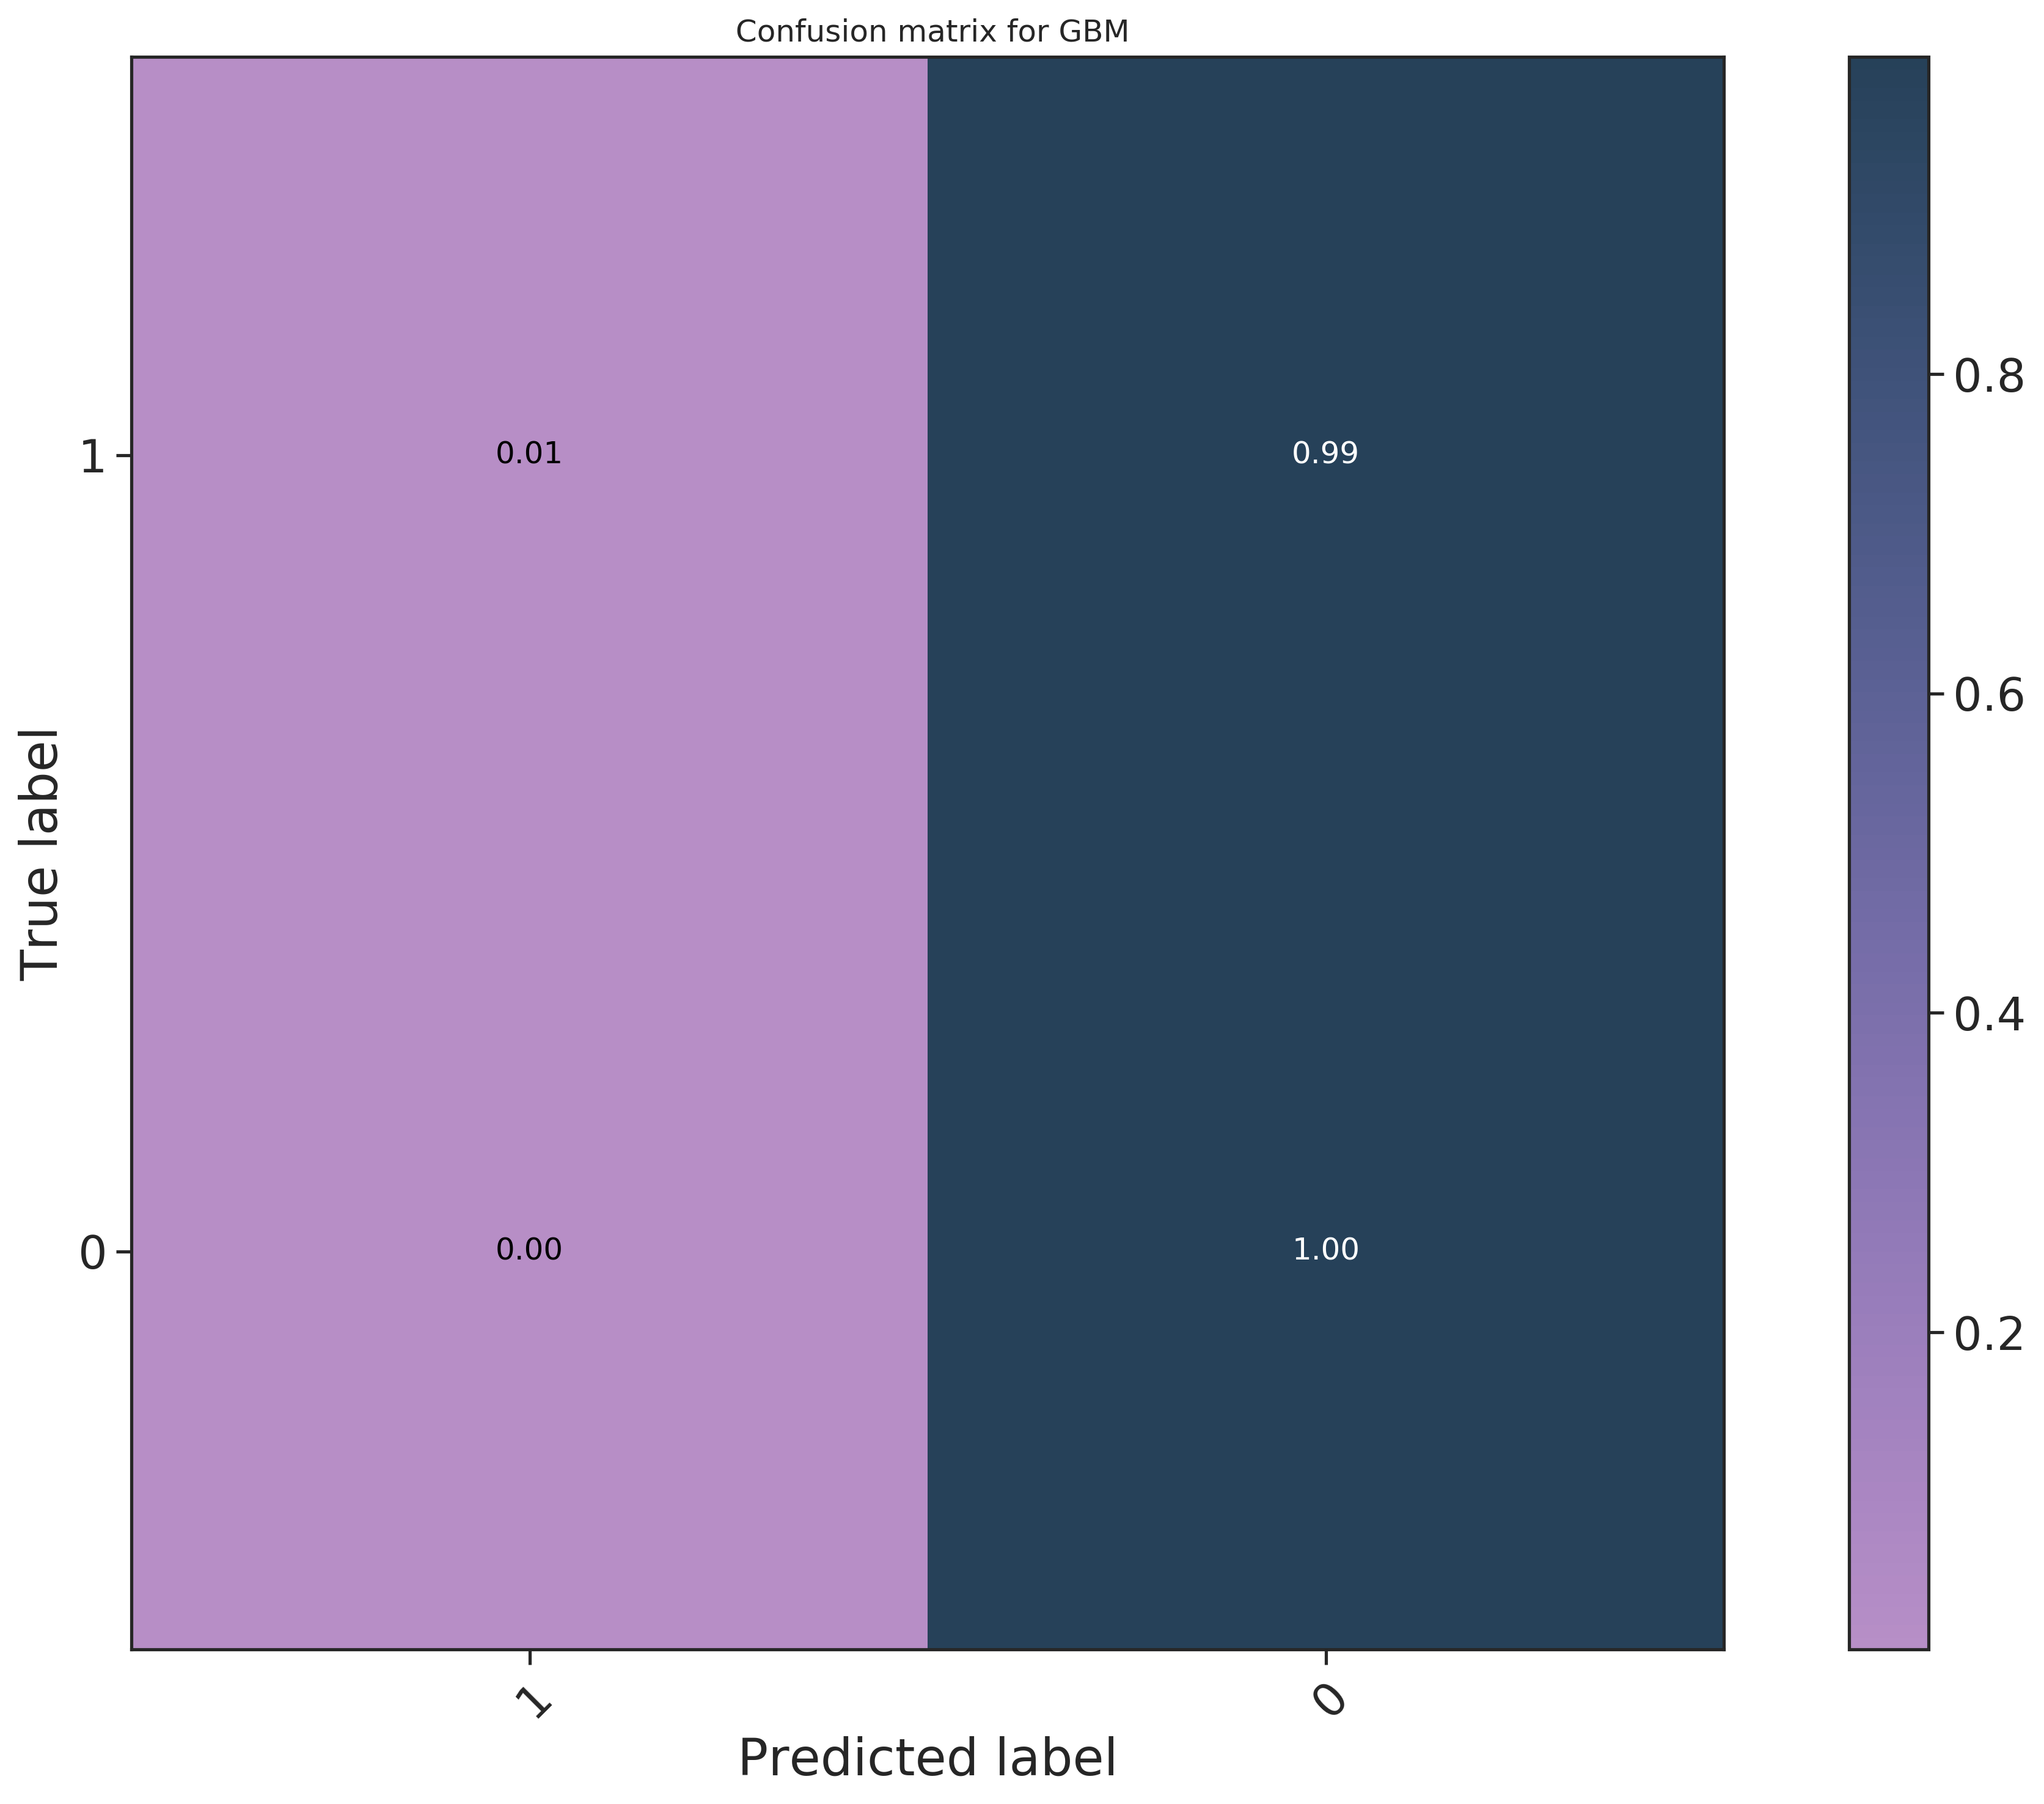

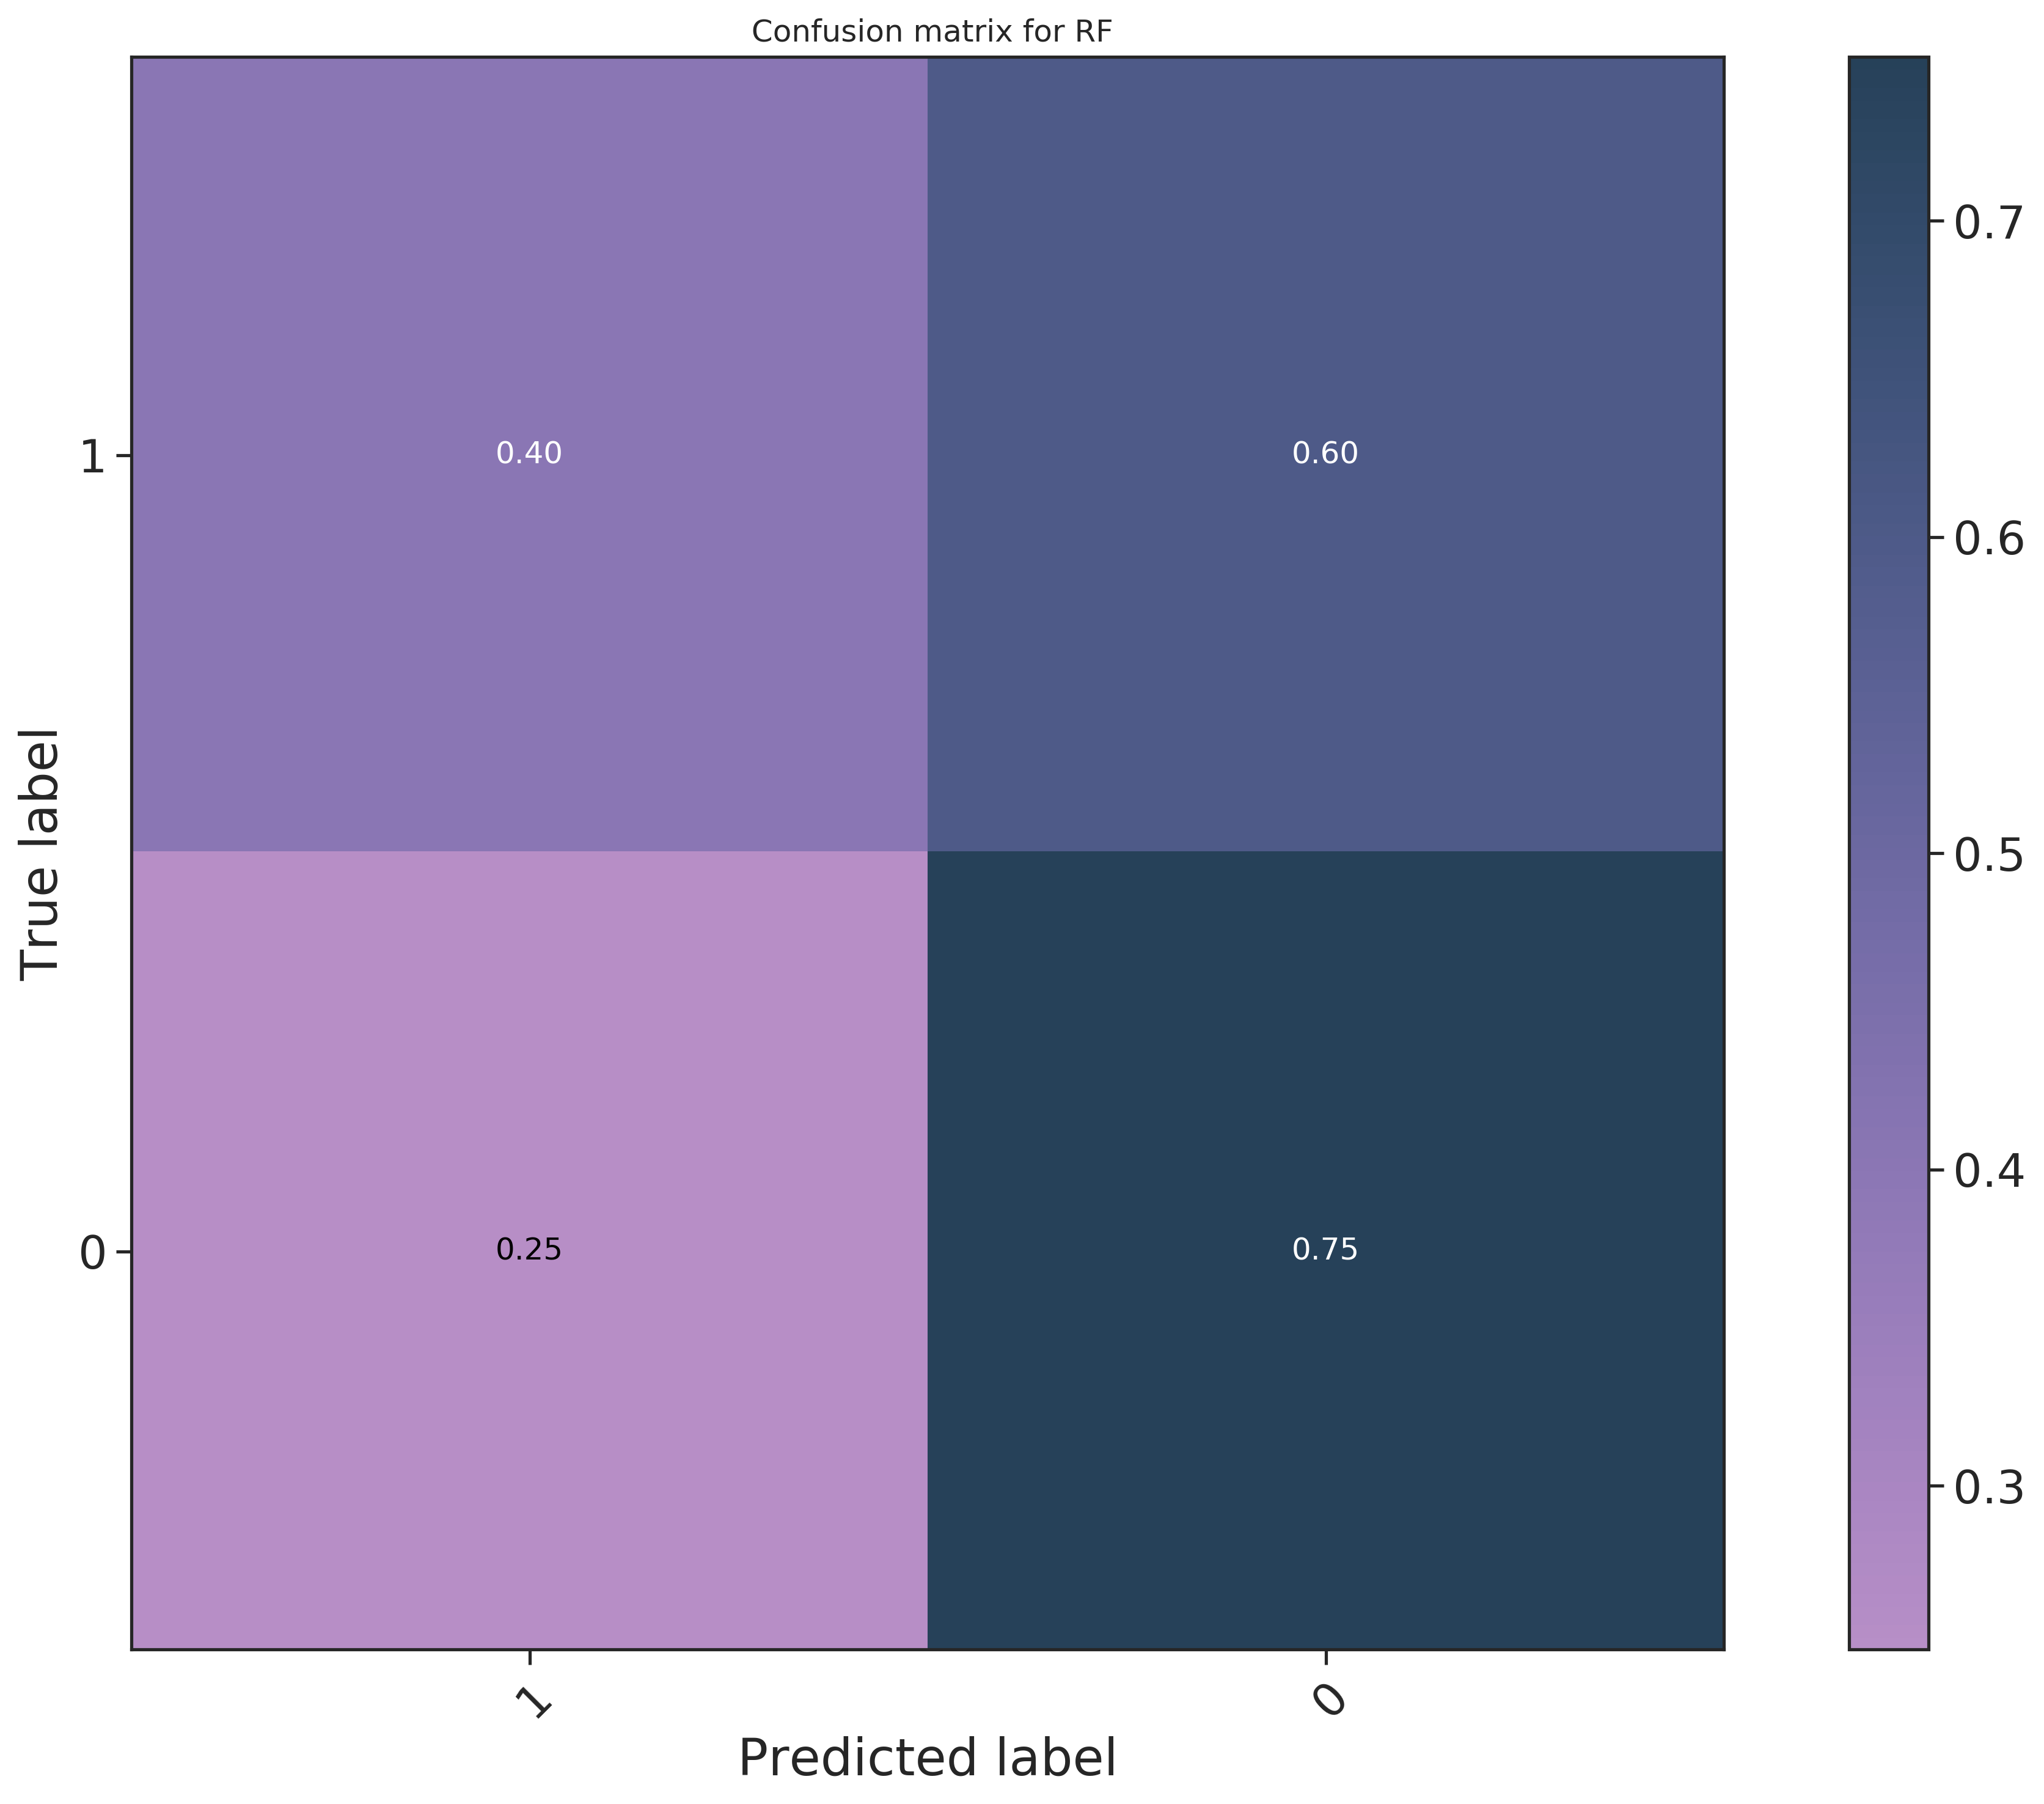

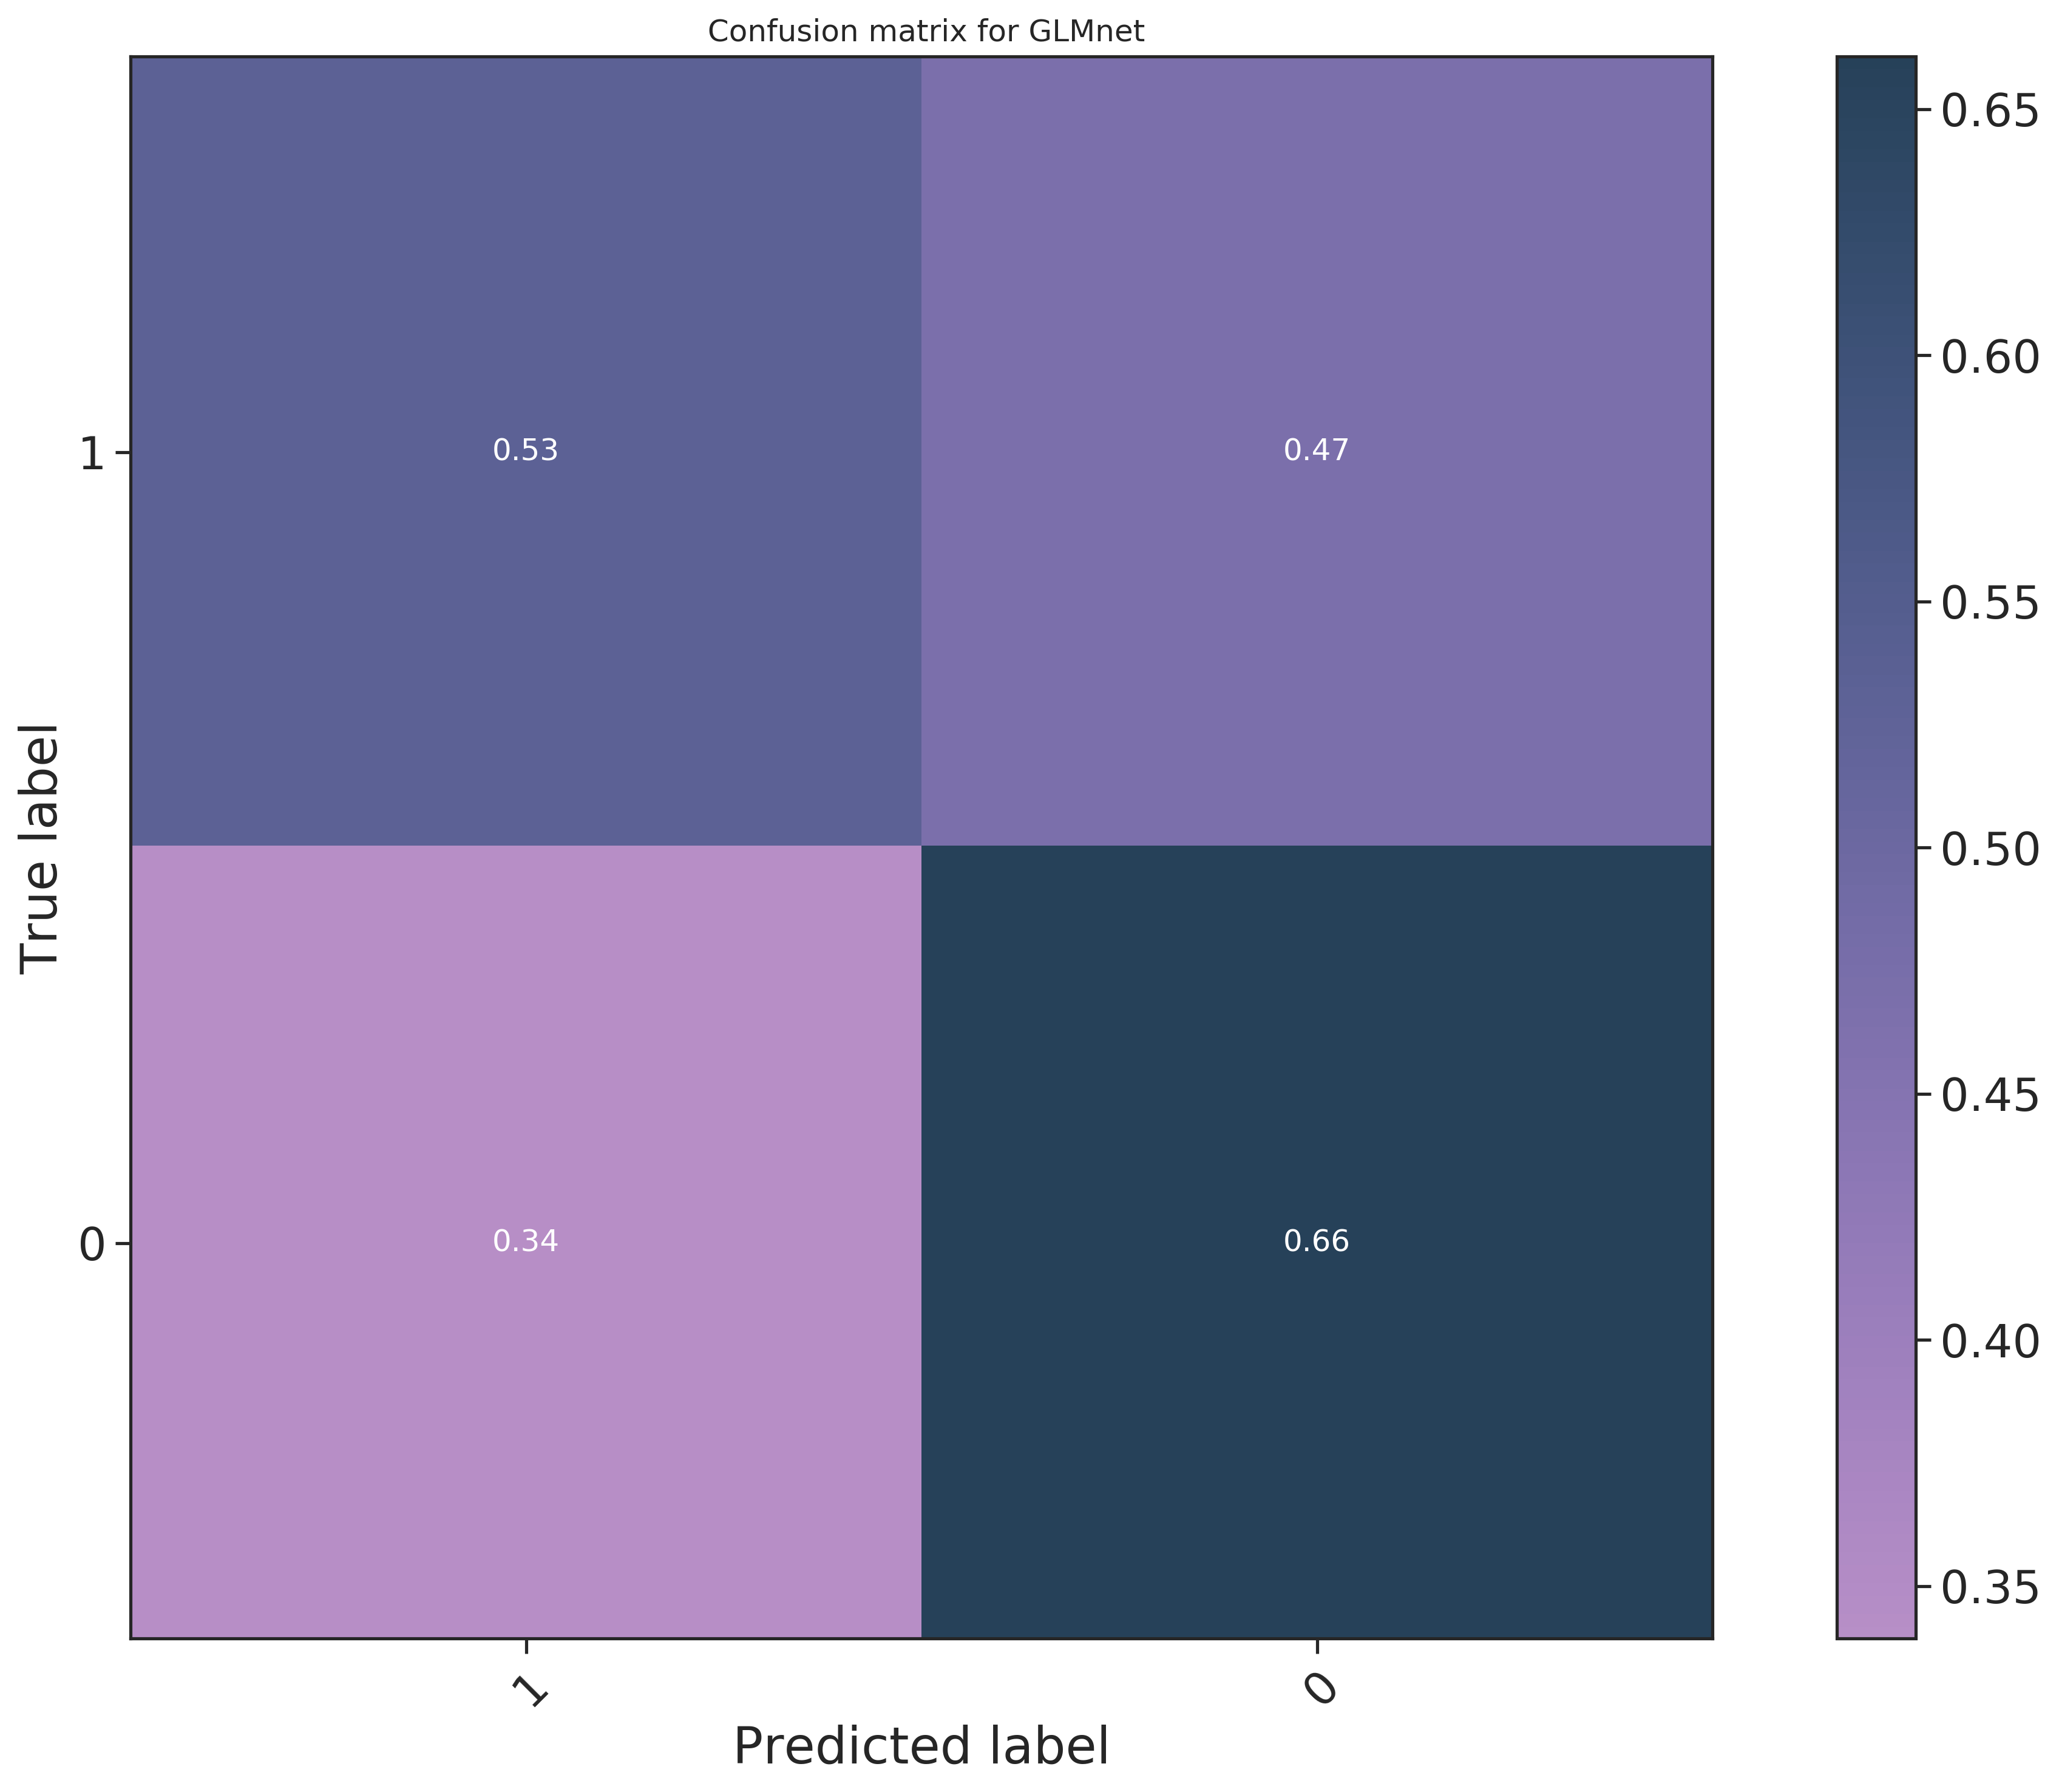

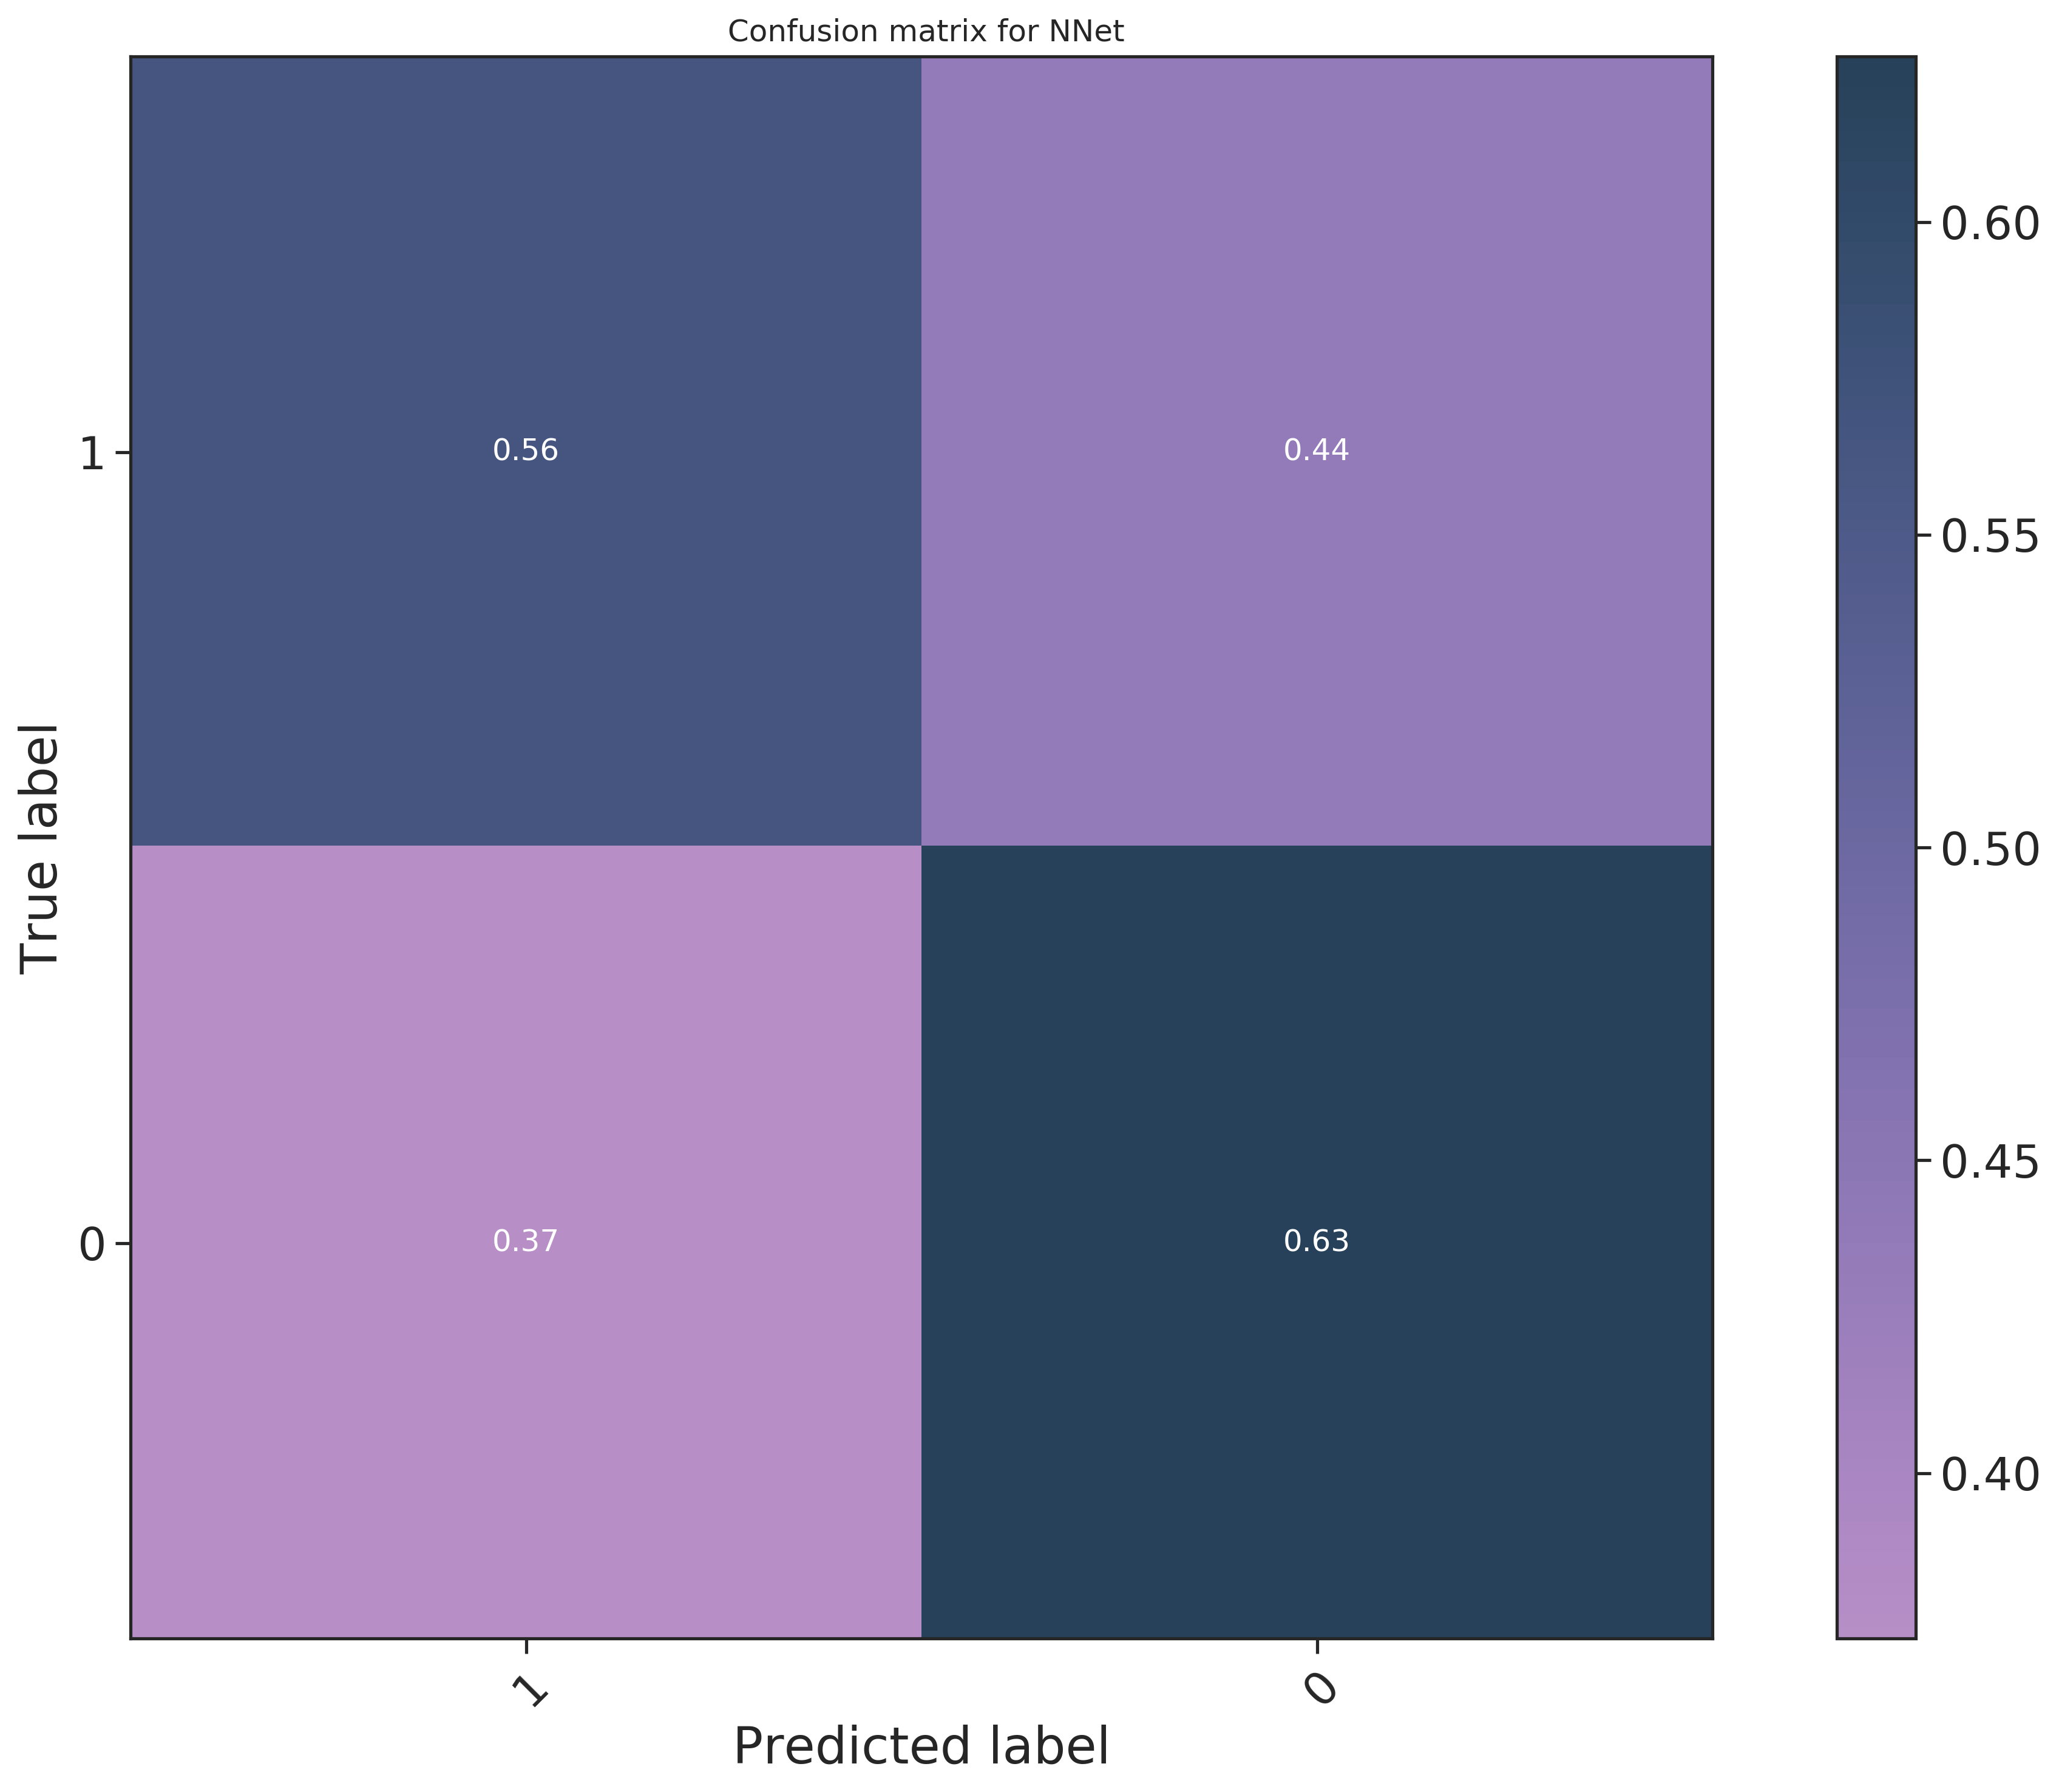

In [77]:
print_confusion_matrices("recall")

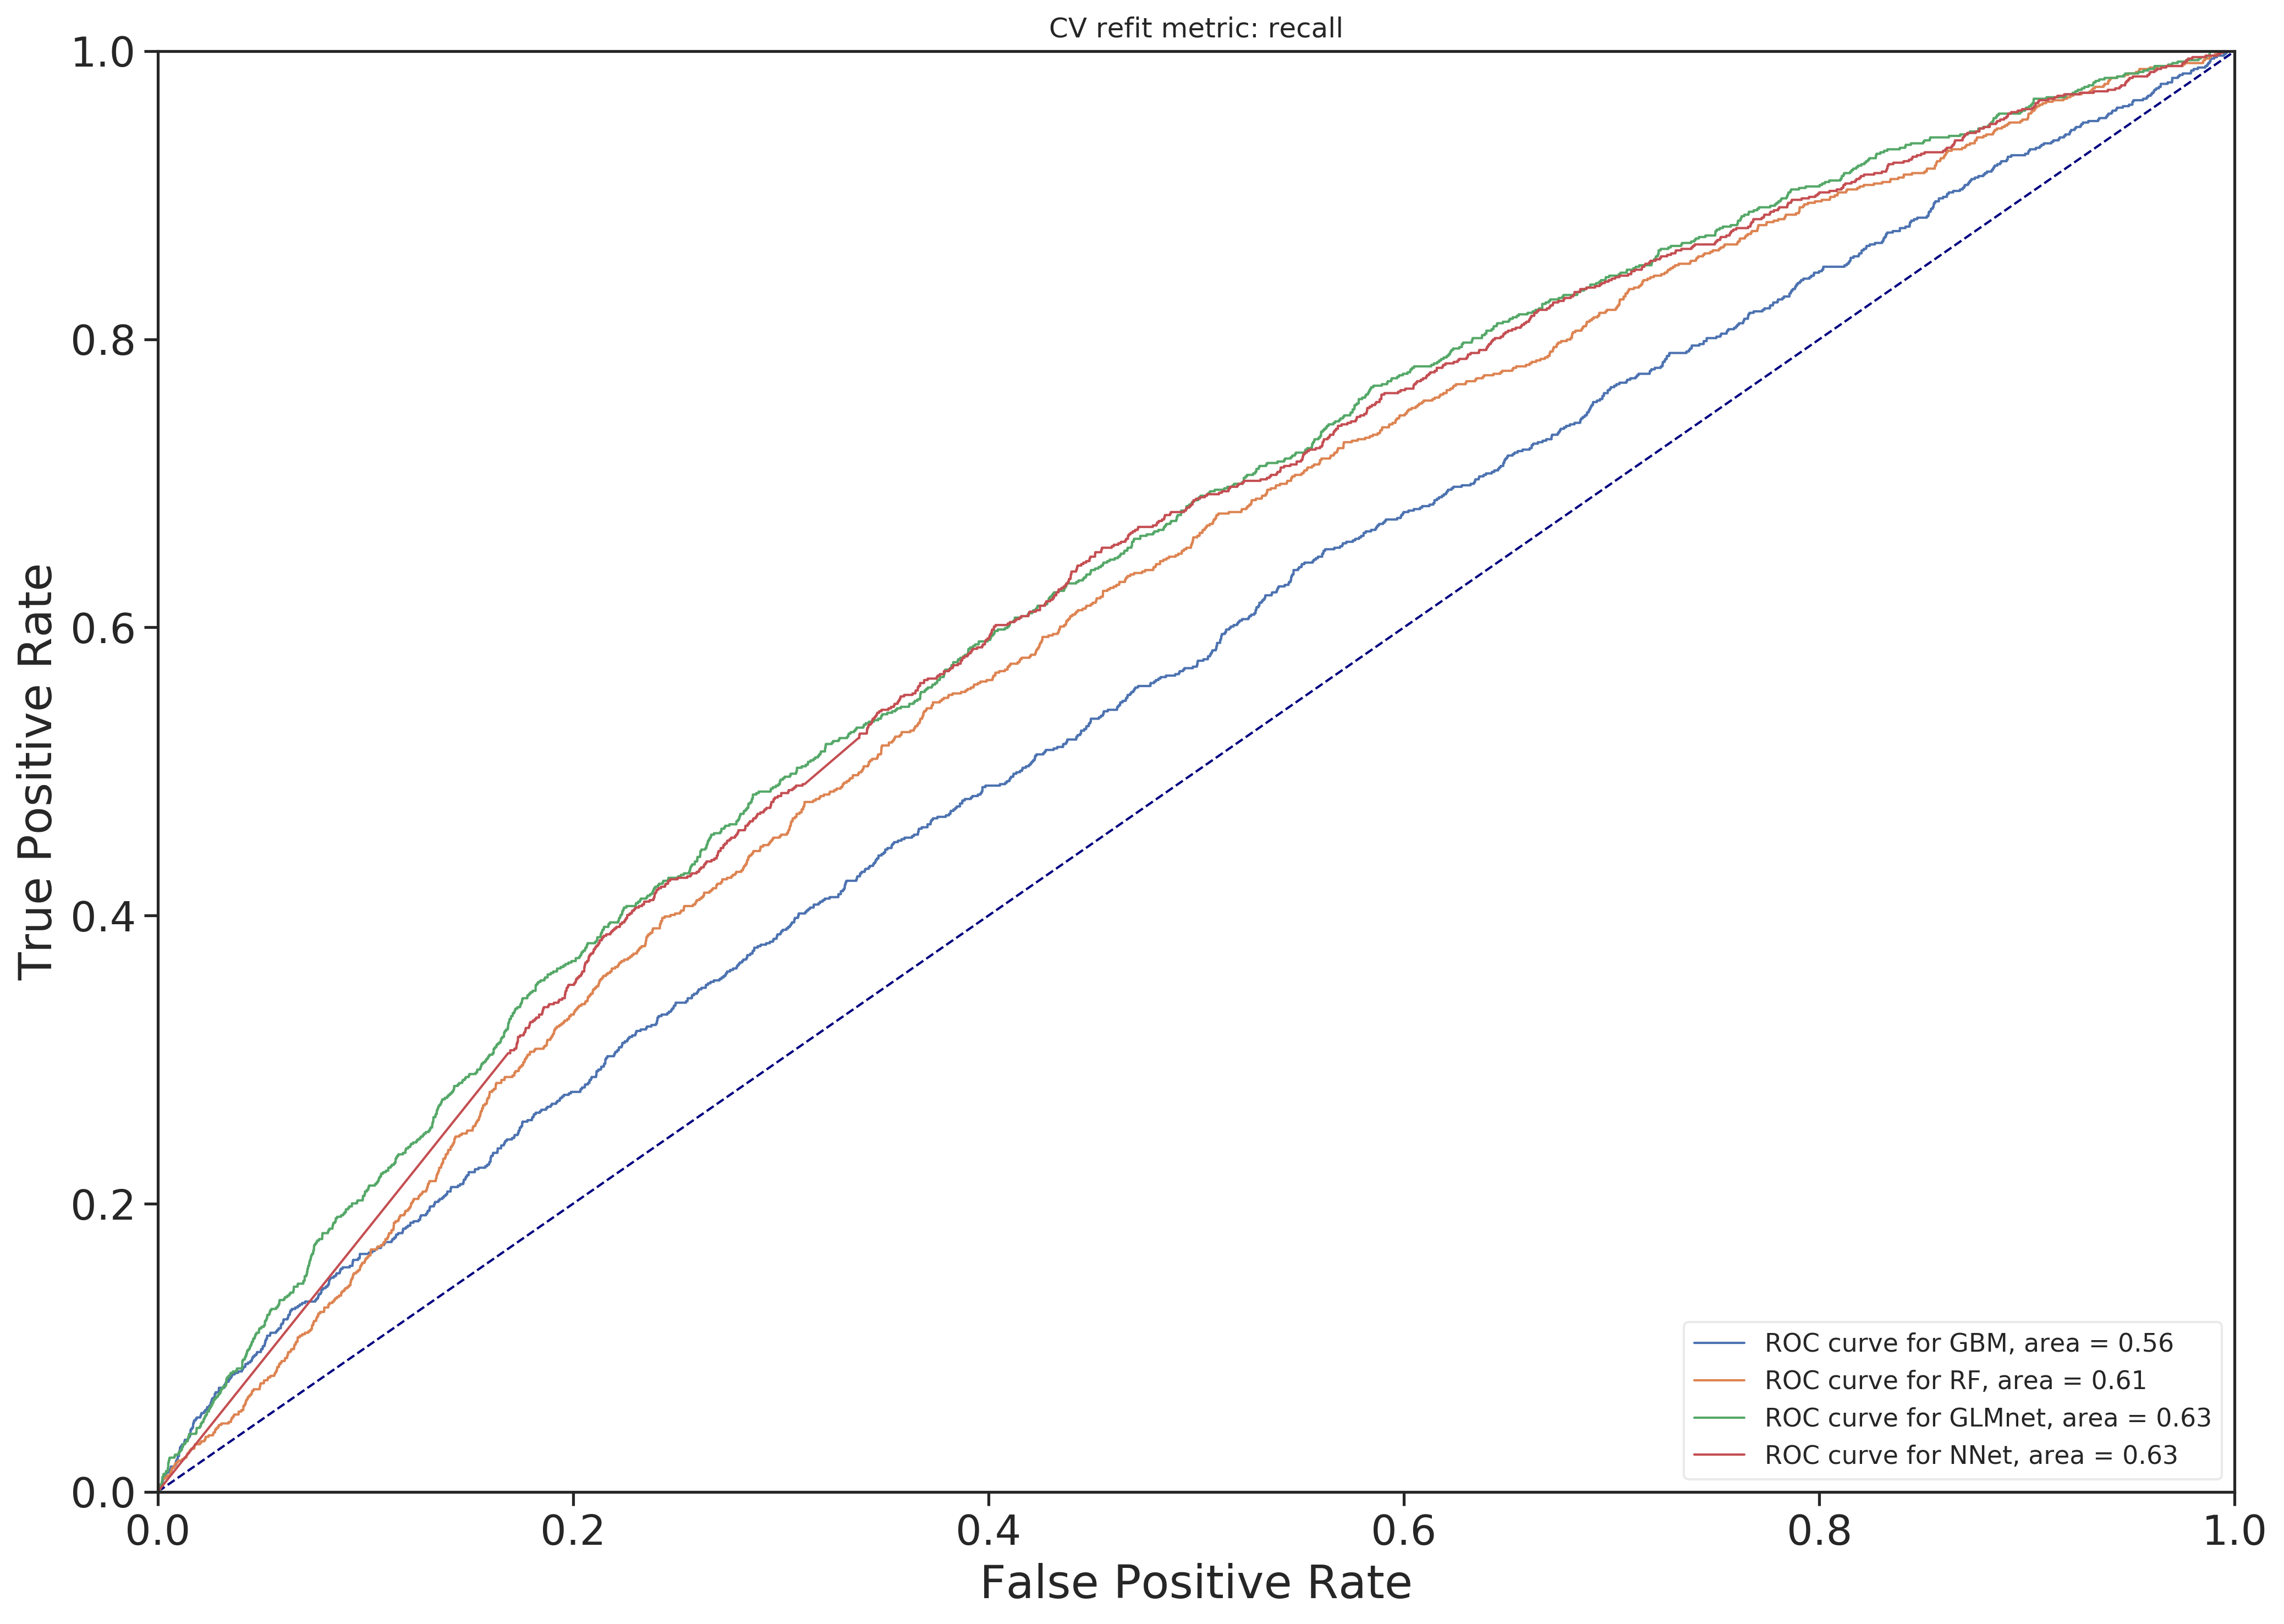

In [78]:
print_roc_auc_curve("recall")

## Refitting for best logloss

In [79]:
run_experiments(X_train.values, y_train.values, config=experiment_configs, scoring=scoring, cv=cv, refit="logloss")

2019-05-13 14:51:35.570176 Skipping RF
2019-05-13 14:51:35.571032 Skipping GBM
2019-05-13 14:51:35.571320 Skipping GLMnet
2019-05-13 14:51:35.571556 Starting gridsearch for NNet
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 23.0min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 44.4min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 62.8min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 63.5min finished


2019-05-13 15:58:43.114967 Storing improved result. Improvement: 13.44443644899519


In [80]:
print_cv_results("logloss")

Model NNet
              precision    recall  f1-score   support

           0       0.96      0.61      0.75     18114
           1       0.07      0.57      0.13       969

   micro avg       0.61      0.61      0.61     19083
   macro avg       0.52      0.59      0.44     19083
weighted avg       0.92      0.61      0.72     19083

Mean scores
   mean_test_logloss  mean_test_recall  mean_test_auc
2             12.444             0.519          0.583
5             12.381             0.511          0.580
7             12.172             0.506          0.580
1             12.048             0.503          0.581
8             12.047             0.496          0.578
0             11.654             0.491          0.581
3              5.899             0.199          0.531
4              3.810             0.100          0.516
6              2.967             0.053          0.507
9              2.861             0.051          0.507
Best params
{'classifier__alpha': 0.592754101835855, 'cl

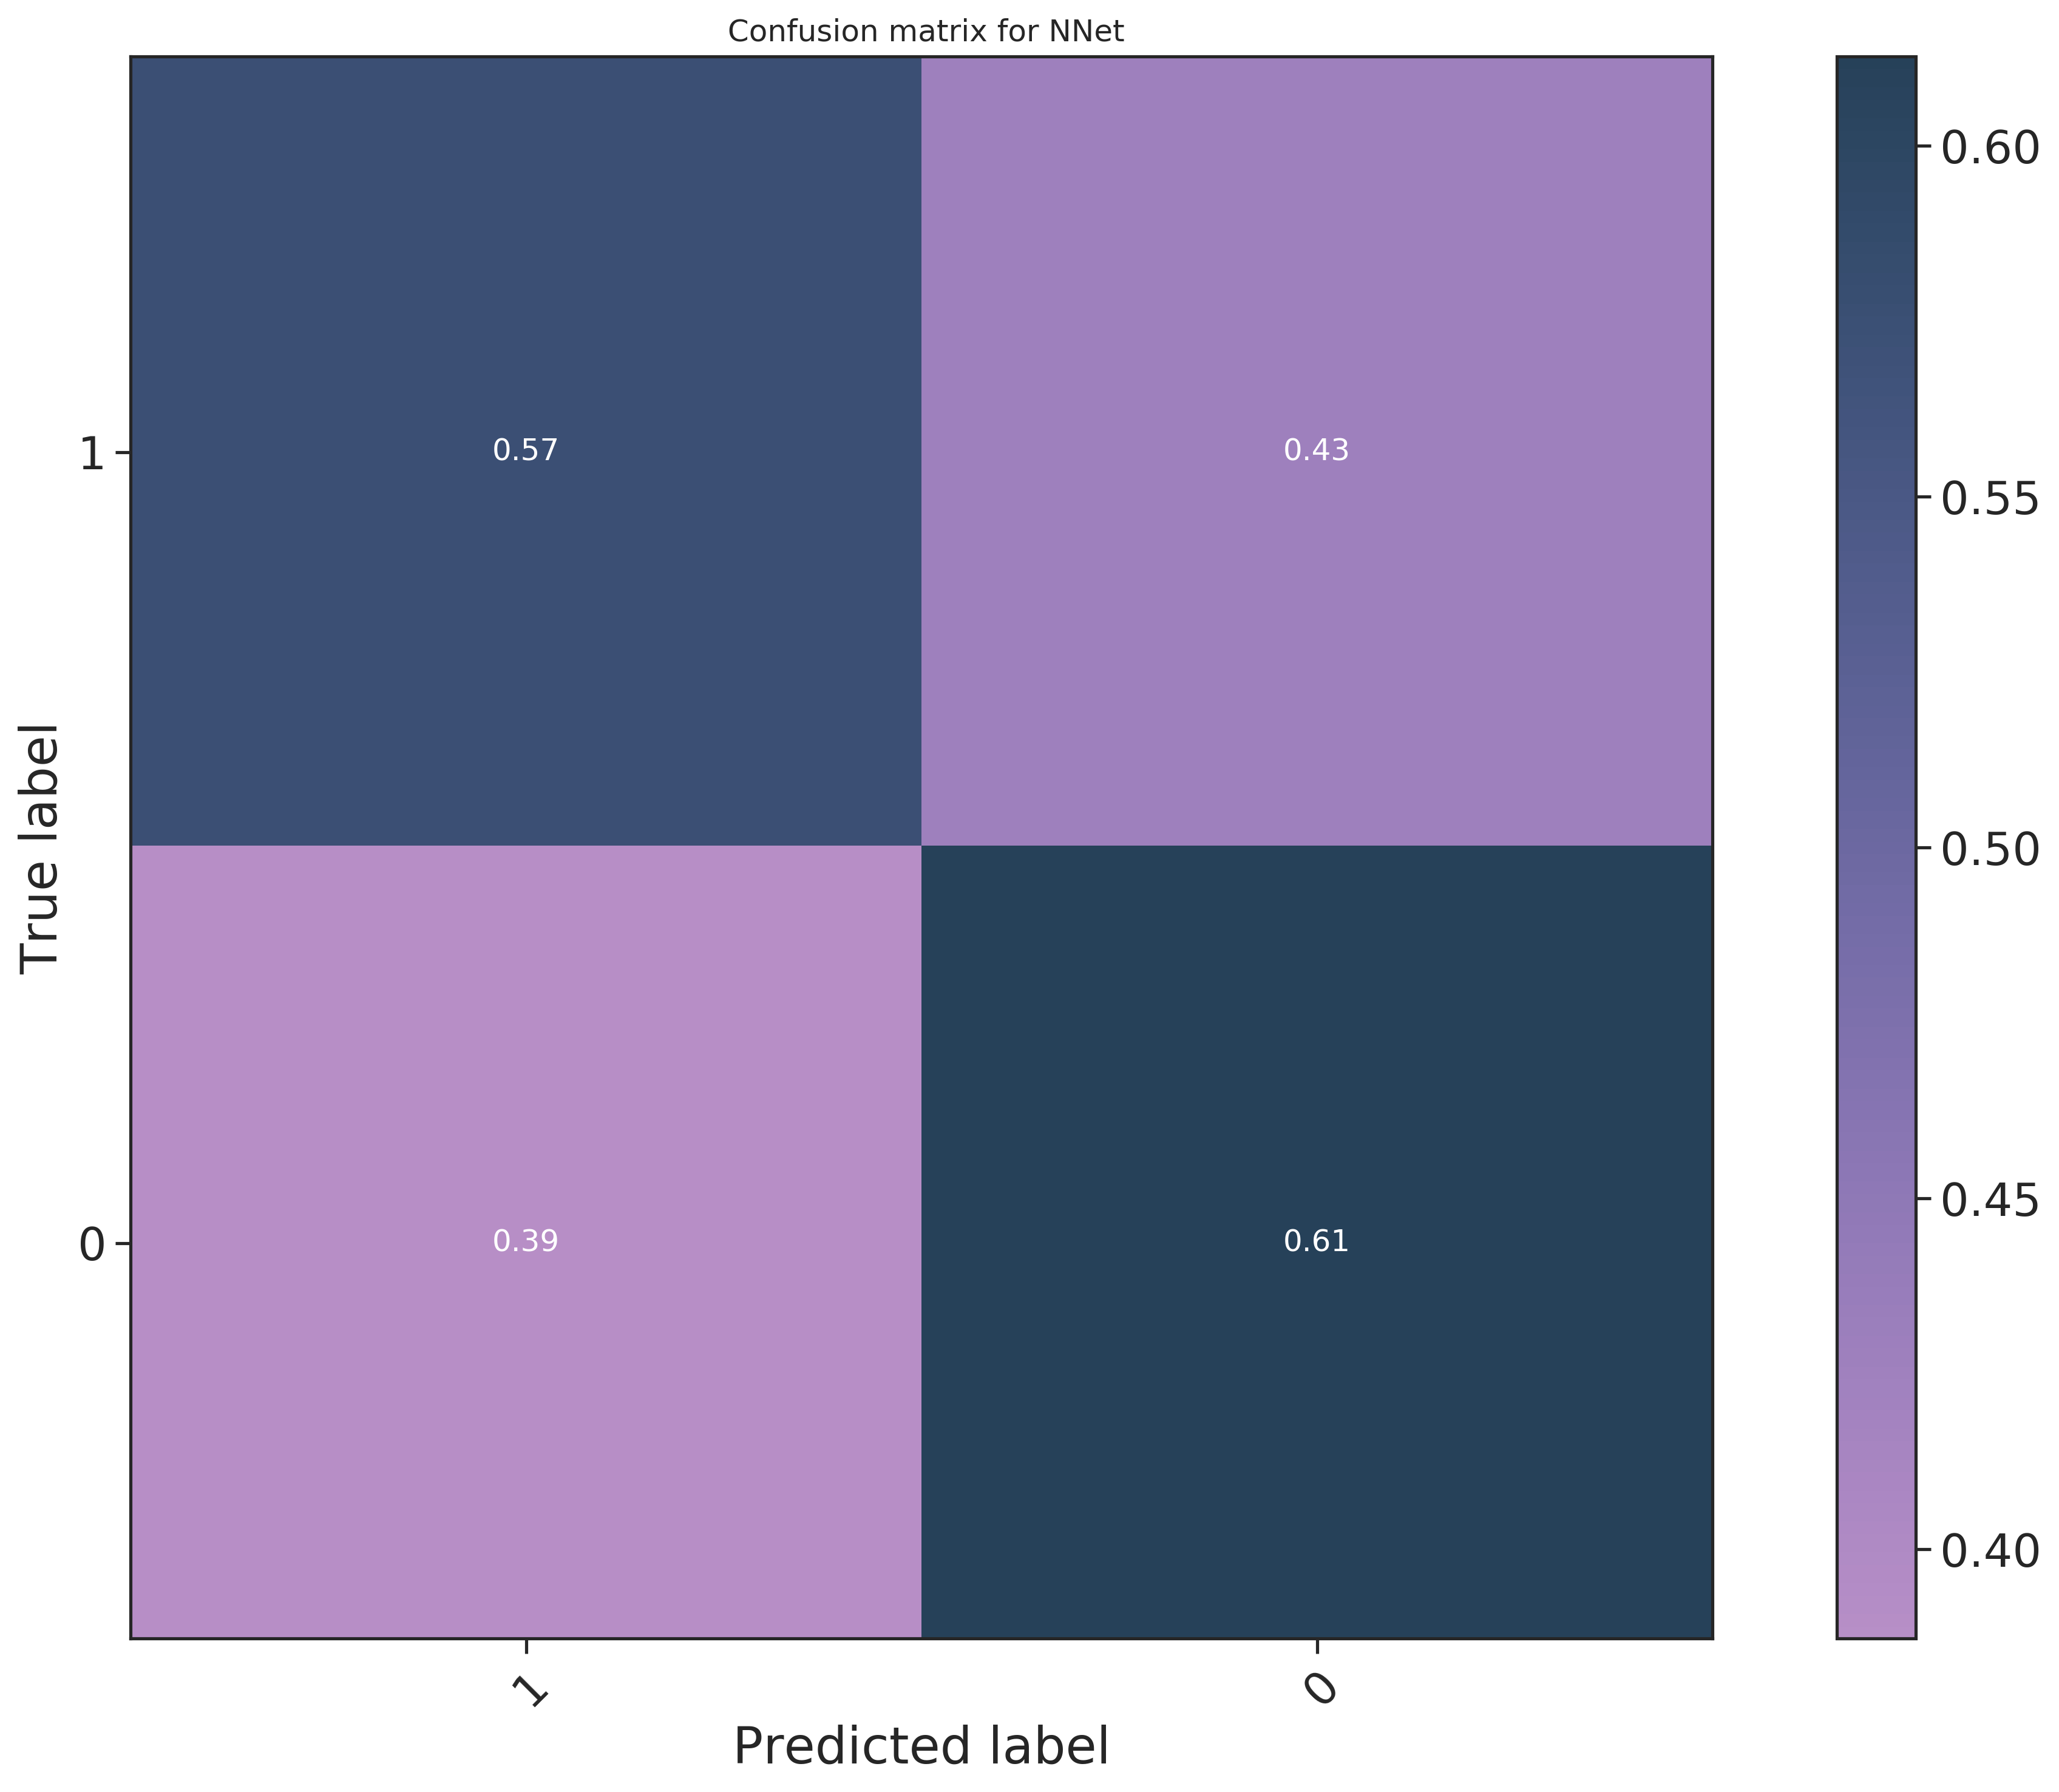

In [81]:
print_confusion_matrices("logloss")

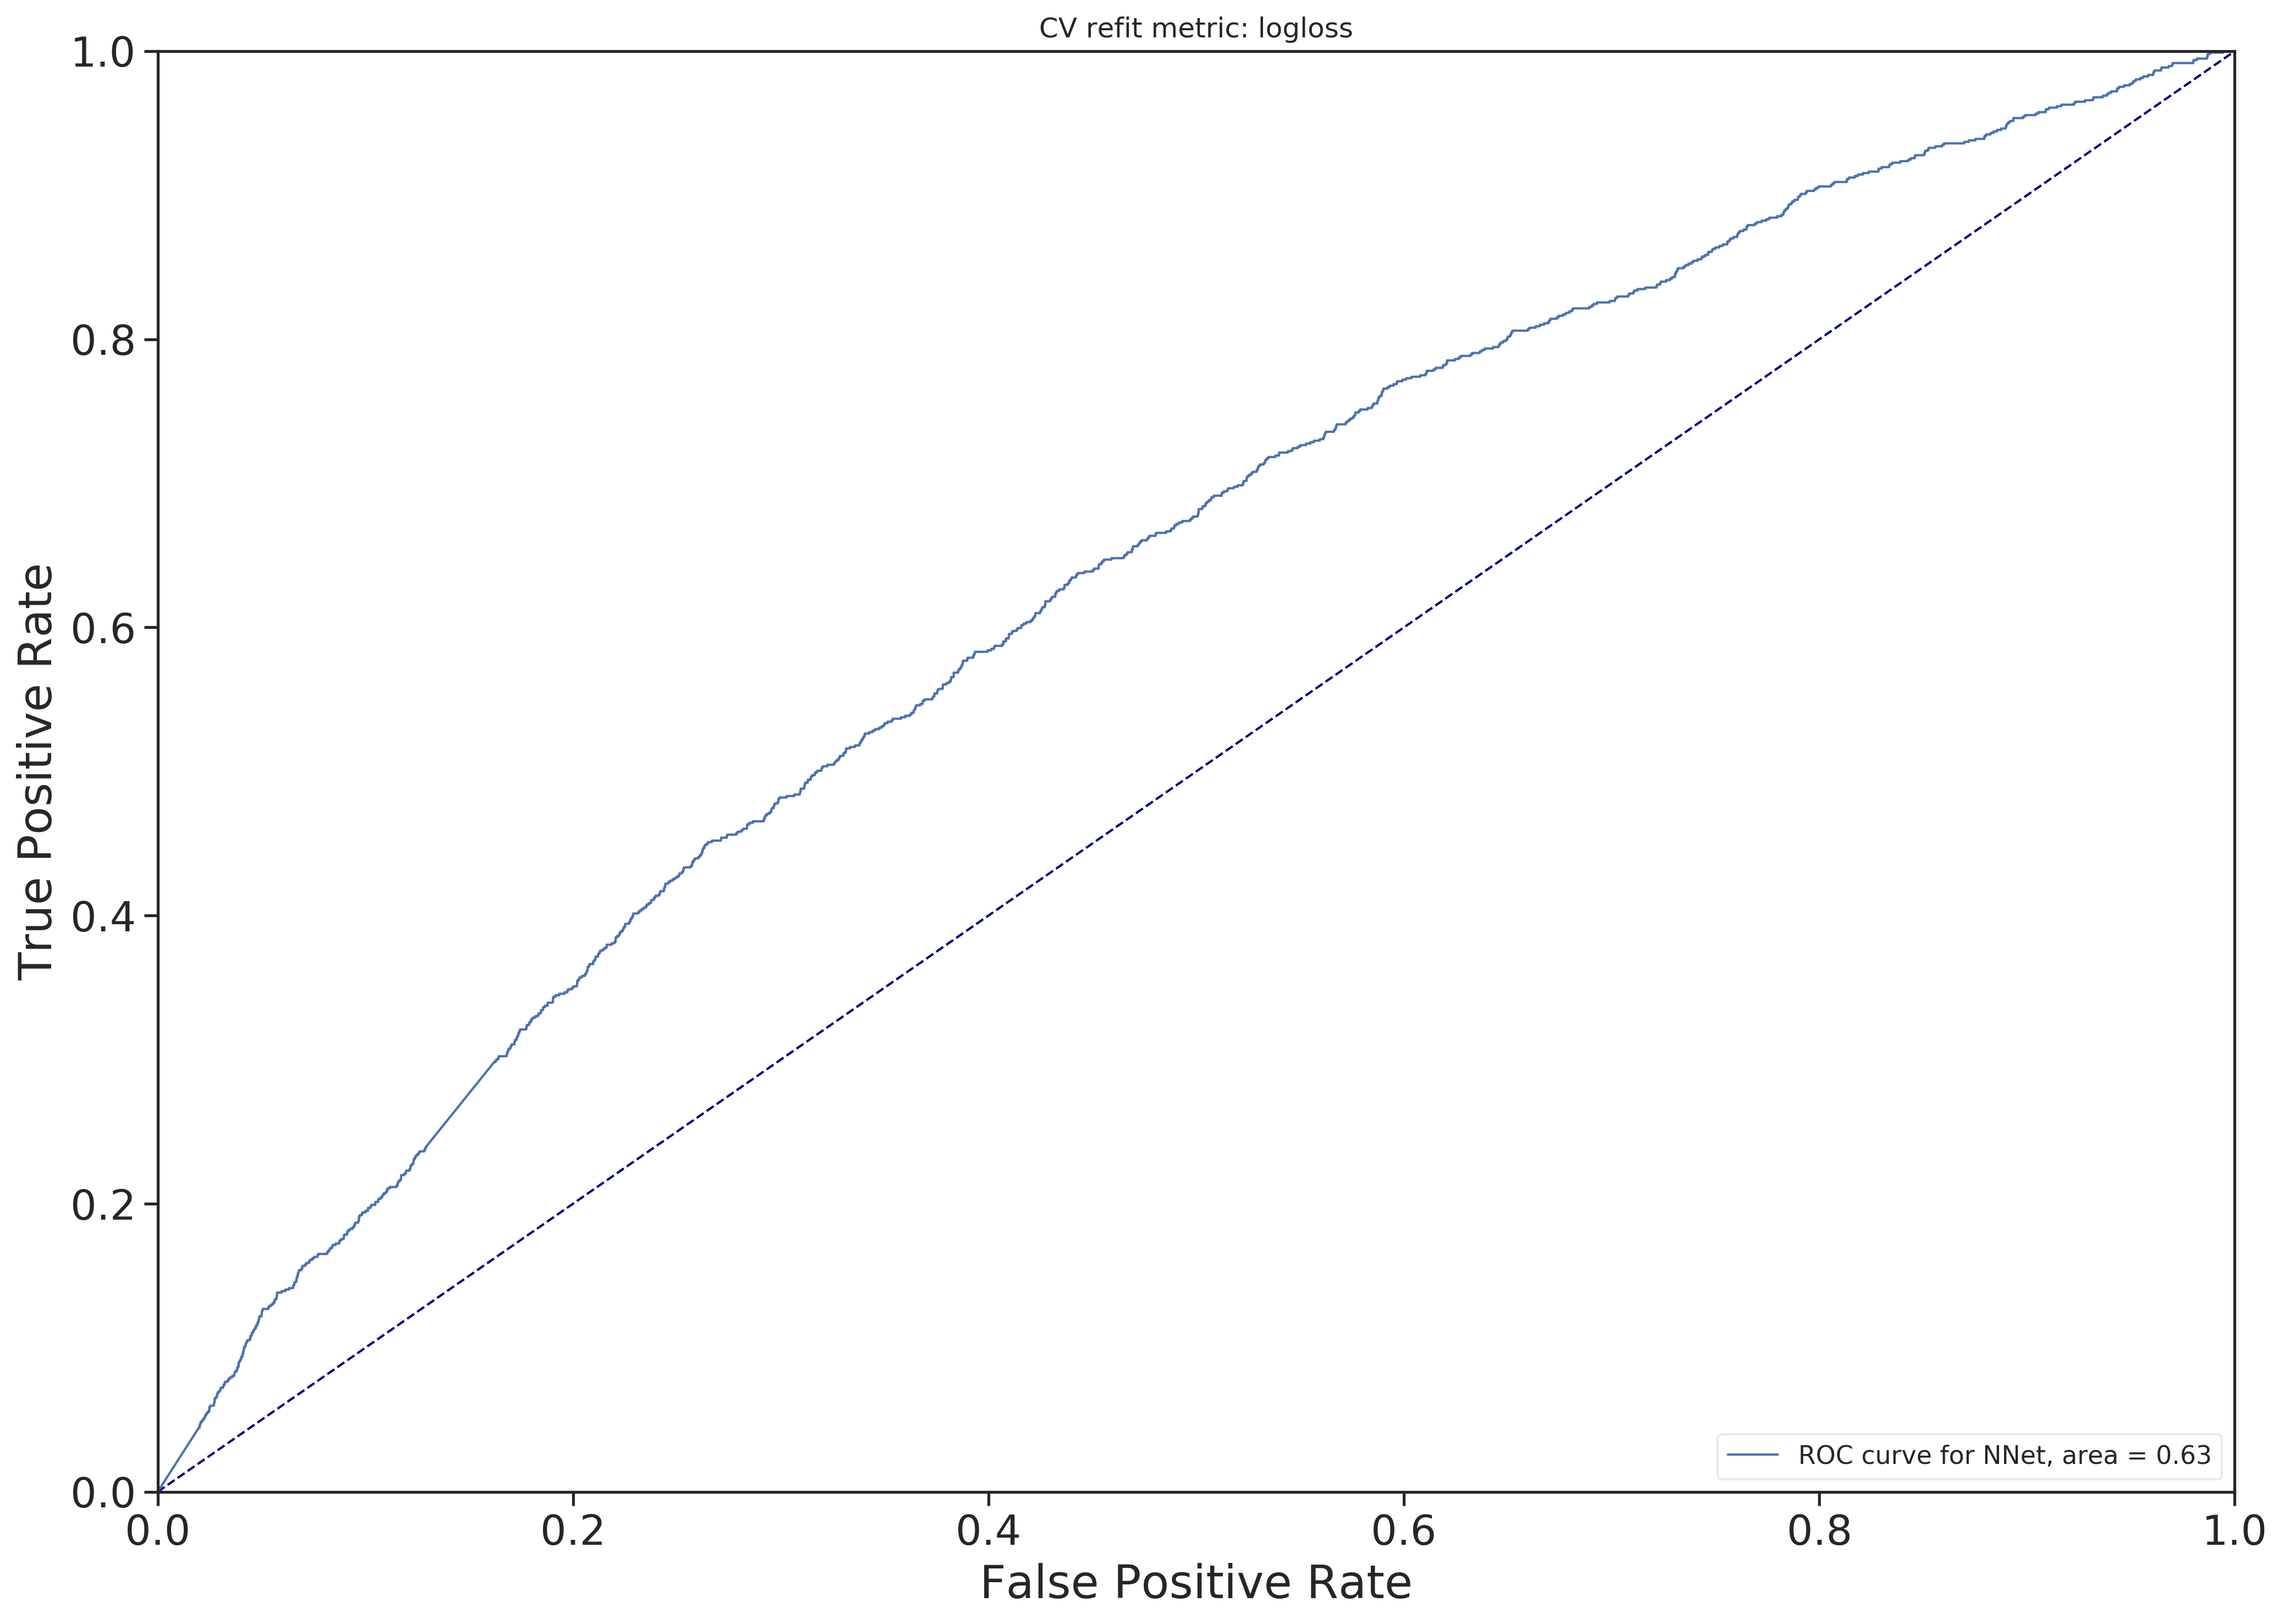

In [82]:
print_roc_auc_curve("logloss")

## Refitting for best roc_auc 

In [83]:
run_experiments(X_train.values, y_train.values, config=experiment_configs, scoring=scoring, cv=cv, refit="auc")

2019-05-13 15:58:55.772418 Skipping RF
2019-05-13 15:58:55.773186 Skipping GBM
2019-05-13 15:58:55.786341 Skipping GLMnet
2019-05-13 15:58:55.786715 Starting gridsearch for NNet
Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 24.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 40.9min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 58.6min
[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed: 68.5min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 71.0min finished


2019-05-13 17:13:45.224742 Storing improved result. Improvement: 1.5836987663073918


In [84]:
print_cv_results("auc")

Model NNet
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     18114
           1       0.08      0.52      0.13       969

   micro avg       0.66      0.66      0.66     19083
   macro avg       0.52      0.59      0.46     19083
weighted avg       0.92      0.66      0.76     19083

Mean scores
   mean_test_logloss  mean_test_recall  mean_test_auc
3             12.965             0.529          0.579
1             12.622             0.527          0.584
4             12.229             0.513          0.583
8             12.471             0.510          0.578
2             12.315             0.509          0.580
5             11.955             0.502          0.582
0             10.826             0.442          0.571
6              9.739             0.389          0.562
9              9.360             0.378          0.563
7              5.908             0.208          0.535
Best params
{'classifier__alpha': 0.5824345021005275, 'c

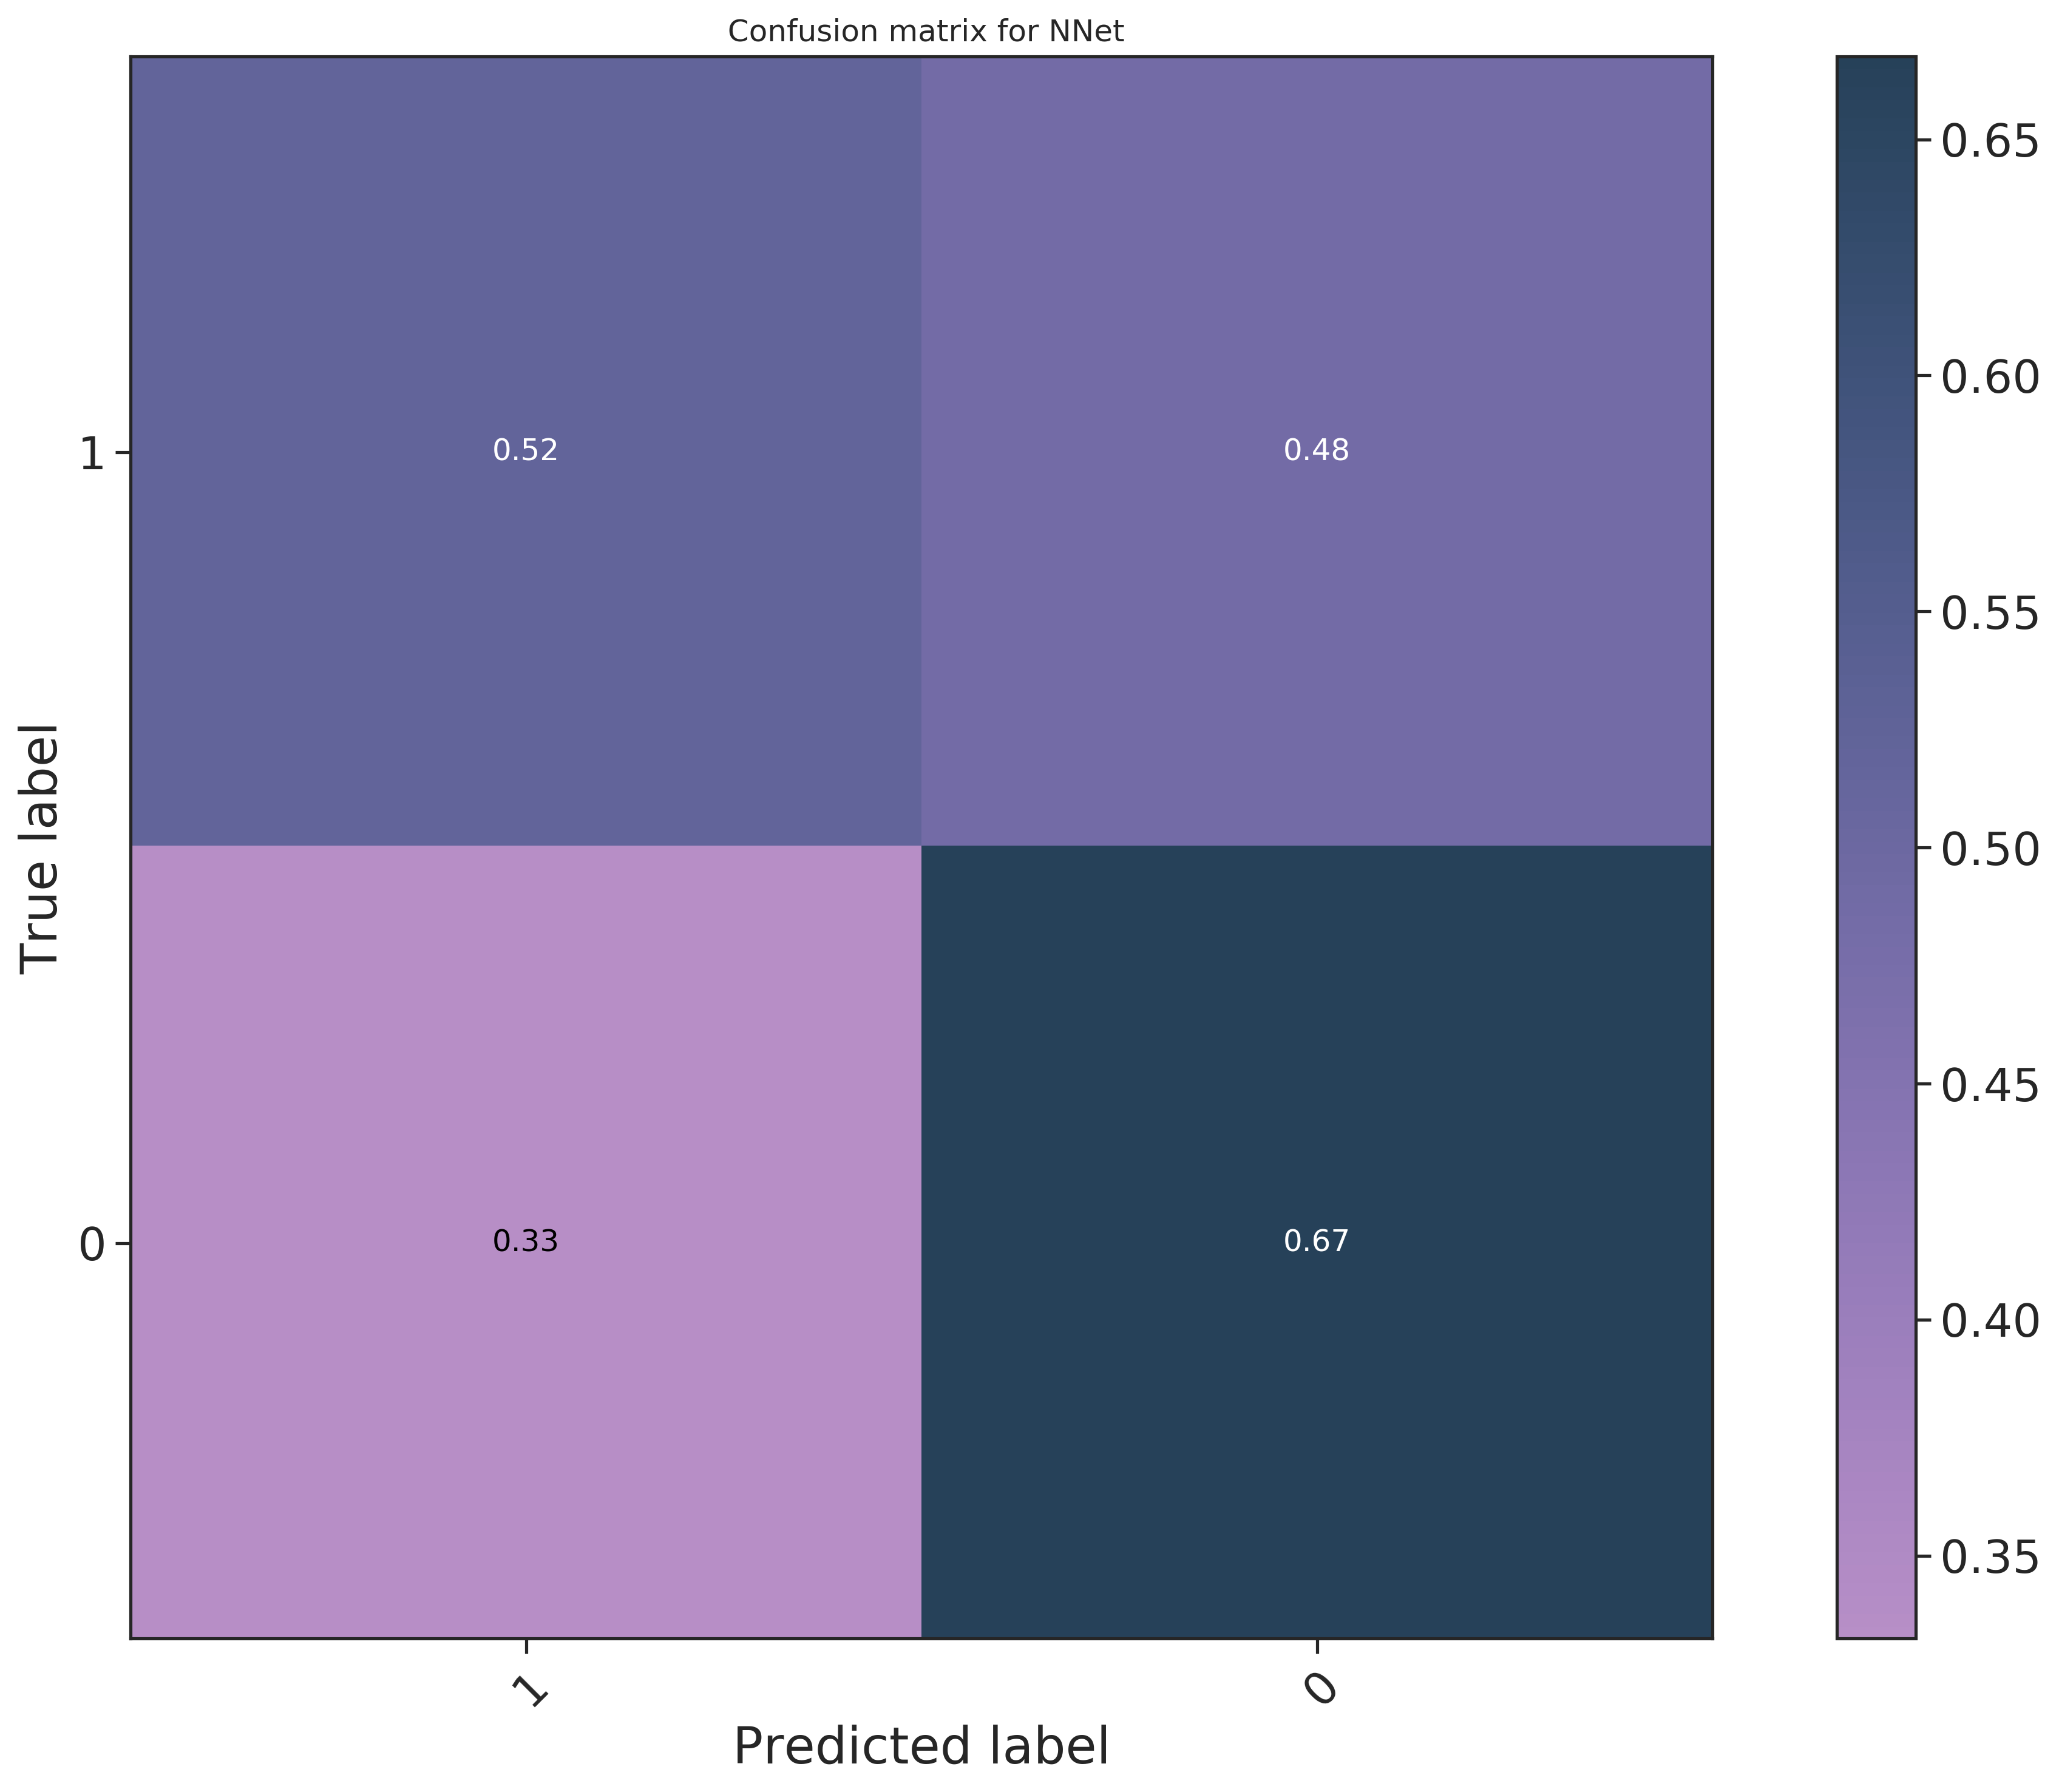

In [85]:
print_confusion_matrices("auc")

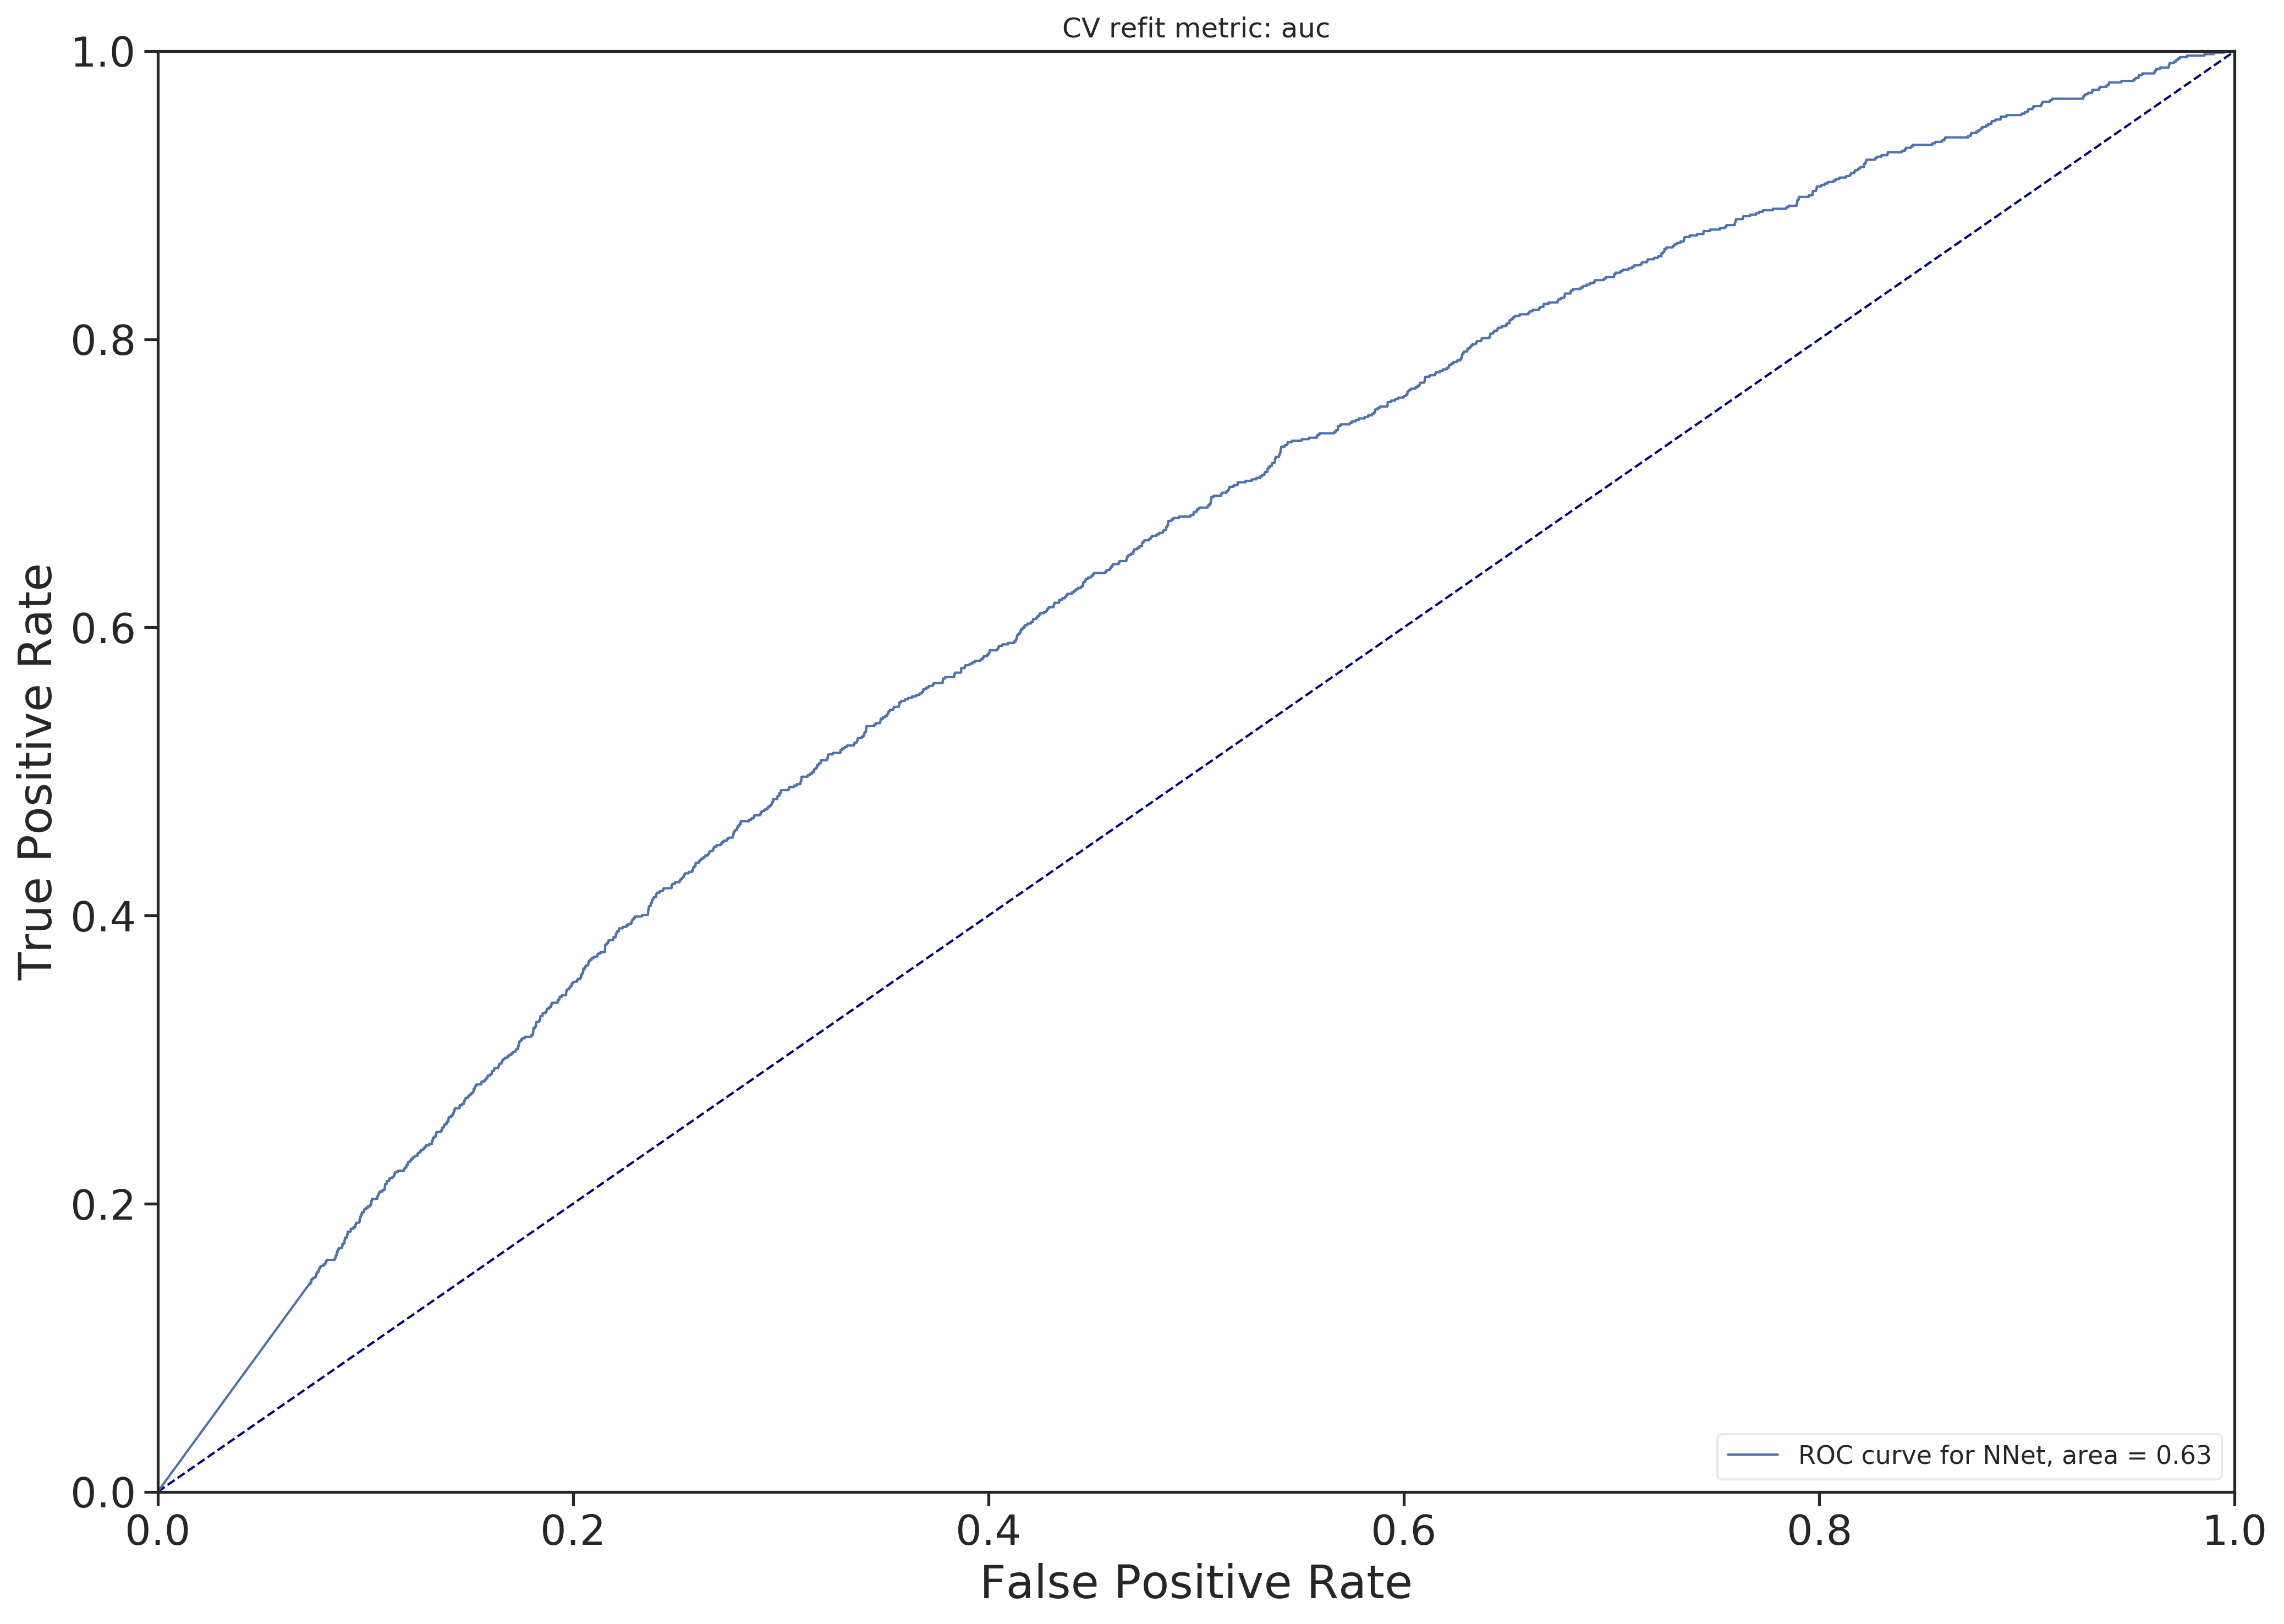

In [86]:
print_roc_auc_curve("auc")

## XGBoost specific

In [ ]:
gridsearch_results["GBM"]["best_estimator"].named_steps["classifier"].evals_result()

In [ ]:
eval_results_xgb = gridsearch_results["GBM"]["best_estimator"].named_steps["classifier"].evals_result()

epochs = len(eval_results_xgb['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, eval_results_xgb['validation_0']['error'], label='Train')
ax.plot(x_axis, eval_results_xgb['validation_1']['error'], label='val')
logl_min = min(eval_results_xgb['validation_1']['error'])
logl_index = eval_results_xgb['validation_1']['error'].index(logl_min)
ax.plot((logl_index, logl_index), (0, logl_min), 'k-')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

## Random Forest specific

In [ ]:
best_model_rf.get_params()

In [ ]:
y_scores = best_model_rf.predict_proba(X_val_all_relevant)[:,1]

In [ ]:
p, r, thresholds = precision_recall_curve(y_val, y_scores)

In [ ]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_val, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0., 1.01]);
    plt.xlim([0., 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [ ]:
precision_recall_threshold(p,r,thresholds, t=0.43)

In [ ]:
plot_precision_recall_vs_threshold(p,r,thresholds)

In [ ]:
kdd98_learn_feat_all_relevant.columns.values

In [ ]:
important_features_rf = best_estimator_rf.feature_importances_
important_features_rf = pd.DataFrame(data=important_features_rf, index=kdd98_learn_feat_all_relevant.columns.values, columns=["feature_importance"])

In [ ]:
important_features_rf = important_features_rf.sort_values(ascending=False, by="feature_importance")

In [ ]:
plt.rcParams['figure.figsize'] = (18, 10)
important_features_rf.head(n=40).sort_values(ascending=True, by="feature_importance").plot.barh()

# Learning on imbalanced data 

In [ ]:
# Scoring methods for grid seach
scoring_imb = {"auc": make_scorer(roc_auc_score, {"sample_weights": sample_weight}),
           "logloss": make_scorer(log_loss, {"sample_weights": sample_weight})
           "recall": make_scorer(recall_score, {"sample_weights": sample_weight})}

In [ ]:
experiment_configs_imb = {
    m: {
        "param_grid": None,
        "pipeline": None,
        "fit_params": None,
        "run": True
    }
    for m in ["RF", "GBM", "GLMnet", "NNet"]
}

np.random.seed(seed=Config.get("random_seed")) # needed for RV generators in the parameter grids

## Random Forest

In [ ]:
rf_classifier = RandomForestClassifier(
    min_impurity_decrease=1e-7,
    class_weight="balanced",
#    max_depth=6,
    max_features=36, # disabled for PCA
    min_samples_split=4,
    random_state=Config.get("random_seed"))

rf_pipe = Pipeline([
    ("classifier", rf_classifier)])

{'classifier__max_depth': 6, 'classifier__max_features': 36, 'classifier__min_samples_split': 4, 'classifier__n_estimators': 1600, 'sampler__sampling_strategy': 0.5342995640947301}

PCA: {'classifier__max_depth': 5, 'classifier__n_estimators': 1550}

In [ ]:
param_grid_rf = {
    #"classifier__max_depth": sp_rint(4,6),
    "classifier__min_samples_split": sp_rint(2,8),
    "classifier__n_estimators": sp_rint(1500,2000)
}

In [ ]:
experiment_configs_imb["RF"]["param_grid"] = param_grid_rf
experiment_configs_imb["RF"]["pipeline"] = rf_pipe

## Gradient Boosting

In [ ]:
gbm_classifier = XGBClassifier(
    booster="gbtree",
    subsample=0.5,
    colsample_bytree=0.5,
    max_depth=4,
    max_delta_step=4,
    n_estimators=2000,
    seed=Config.get("random_seed"),
    verbose=2,
    silent=False)

gbm_pipe = Pipeline([
    ("classifier", gbm_classifier)
])

{'classifier__colsample_bytree': 0.5505199419576297, 'classifier__learning_rate': 0.10393774484000626, 'classifier__max_delta_step': 4, 'classifier__max_depth': 4, 'sampler': None}

In [ ]:
param_grid_gbm = {
    "classifier__learning_rate": sp_unif(loc=0.05, scale=0.15),
}

In [ ]:
experiment_configs_imb["GBM"]["param_grid"] = param_grid_gbm
experiment_configs_imb["GBM"]["pipeline"] = gbm_pipe
experiment_configs_imb["GBM"]["fit_params"] = {
    "classifier__early_stopping_rounds": 10,
    "classifier__eval_metric": "recall",
    "classifier__eval_set": [(X_train_all_relevant, y_train), (X_val_all_relevant, y_val)]
}

##  GLMnet

In [ ]:
logitnet = LogitNet(
    n_splits=5,
    scoring="recall",
    standardize=True,
    random_state=Config.get("random_seed"))

glmnet_scaler = Rescaler(transformer="ptrans")

glmnet_pipe = Pipeline([
    ("scaler", glmnet_scaler),
    ("classifier", logitnet)
])

{'logitnet__alpha': 0, 'rescaler__transformer': 'ptrans', 'sampler__sampling_strategy': 0.5979156875146854}

In [ ]:
param_grid_glmnet = {
    "classifier__alpha": sp_unif(0,1),
    "classifier__max_features": sp_rint(1, 50) 
}

In [ ]:
experiment_configs_imb["GLMnet"]["param_grid"] = param_grid_glmnet
experiment_configs_imb["GLMnet"]["pipeline"] = glmnet_pipe

## Nnet 

In [ ]:
nnet = MLPClassifier(solver="adam",
                     hidden_layer_sizes=(25,11,7,5,3,),
                     learning_rate_init=0.01,
                     early_stopping=True,
                     random_state=Config.get("random_seed"))

nnet_scaler = Rescaler(transformer="ptrans")

nnet_pipe = Pipeline([
    ("scaler", nnet_scaler),
    ("classifier", nnet)
])

{'nnet__alpha': 0.4282430362906189, 'sampler__sampling_strategy': 0.5663642416770066, 'scaler__transformer': 'ptrans'}

In [ ]:
param_grid_nnet = {
    "classifier__alpha": sp_unif(loc=10e-2, scale=10e-1),
    "classifier__learning_rate_init": sp_unif(loc=0.001,scale=0.5)
}

In [ ]:
experiment_configs_imb["NNet"]["param_grid"] = param_grid_nnet
experiment_configs_imb["NNet"]["pipeline"] = nnet_pipe

In [ ]:
result_store = pathlib.Path(
    Config.get("model_store"), "gridsearch_results_dict_imb.pkl")
if result_store.is_file():
    with open(result_store, "rb") as f:
        gridsearch_results_imp = pickle.load(f)
else:
    gridsearch_results = {
        "GBM": {
            "best_estimator": None,
            "best_score": -1.0,
            "cv_results": None
        },
        "RF": {
            "best_estimator": None,
            "best_score": -1.0,
            "cv_results": None
        },
        "GLMnet": {
            "best_estimator": None,
            "best_score": -1.0,
            "cv_results": None
        },
        "NNet": {
            "best_estimator": None,
            "best_score": -1.0,
            "cv_results": None
        }
    }
    with open(result_store, "wb") as f:
        pickle.dump(gridsearch_results_imb, f)

def update_result(model, gridsearch):
    if not model in ["GBM", "RF", "GLMnet", "NNet"]:
        raise ValueError("Invalid model name")
    previous_score = gridsearch_results_imb[model]["best_score"]
    if gridsearch.best_score_ > previous_score:
        log("Storing improved result. Improvement: {}".format(gridsearch.best_score_-previous_score))
        gridsearch_results[model]["best_estimator"] = gridsearch.best_estimator_
        gridsearch_results[model]["best_score"] = gridsearch.best_score_
        gridsearch_results[model]["cv_results"] = pd.DataFrame(gridsearch.cv_results_)
        
        file_name ="gridsearch_{}_imb.pkl".format(model)
        with open(pathlib.Path(Config.get("model_store"),file_name),"wb") as f:
            pickle.dump(gridsearch, f)
        with open(result_store, "wb") as f:
            pickle.dump(gridsearch_results, f)
    else:
        log("No improvement over previous search for {}".format(model))

In [ ]:
run_experiments(config=experiment_configs_imb, scoring=scoring_imb, cv=cv, refit="recall")